In [3]:
# aa bb cc dd
import numpy as np
print('Numpy version:',np.__version__)
import pandas as pd
import datetime
from datetime import datetime
from datetime import date, timedelta
import ta
import time
import math
import talib
import scipy.stats as stats

import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
import gc
gc.collect()

import itertools
import warnings
warnings.filterwarnings('ignore')
import requests
# -------------------------------------------
import polars as pl
import multiprocessing 

import tensorflow as tf
from kerastuner import HyperModel, RandomSearch
from kerastuner import HyperParameters

# Crear una instancia de HyperParameters
hp = HyperParameters()
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version:',tf.__version__)
tf.config.list_physical_devices()

import tensorflow_addons


from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Ridge, Lasso, RidgeClassifier, LogisticRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import ExtraTreeRegressor, ExtraTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score

Numpy version: 1.23.5


<ipython-input-3-7113d3370dcb>:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Num GPUs Available:  3
Tensorflow version: 2.13.1


In [4]:
def simulacion(df_sim,margens,margeni,margen2s,margen2i,stop,profit,tiempo_5m,cant_señales,show=False):

#     margen_sup=1-margens
#     margen_inf=0+margeni
#     margen_sup_close=1-margen2s
#     margen_inf_close=0+margen2i
    
    df_sim['Close']=df_sim[buscar(df_sim,'Close')]
    df_sim['y']=df_sim[buscar(df_sim,'_y')]
    margen_sup=1-margens
    margen_inf=-1+margeni
    
    margen_sup_close=1-margen2s
    margen_inf_close=-1+margen2i
#     print(margen_sup,margen_inf,margen_sup_close,margen_inf_close)
#     margen_sup=0.9
#     margen_inf=0.1
#     margen_sup_close=0.9
#     margen_inf_close=0.1
    
#     stop=1.1
    dinero=10000
    dinero_inicial=dinero
    comision=0.0004
    compre=False
    vendi=False
    ganancia=0
    # tiempo_5m=10000
    umbral=0.5
    señales=[]
    trade_open=0
    stoploss=0
    # cant_señales=5
    # print('dinero inicial',dinero)
    cont=0
    cont_loss=0
    cont_win=0
    estadoant=0.5
    estadoact=0.5
    for idx,close,señal in zip(df_sim.index,df_sim['Close'],df_sim['y']):    

#         stoploss
        if (compre and (stoploss>=close)) or (compre and (takeprofit<=close)):
            if (compre and (takeprofit<=close)):
                estadoact=2
            else:
                estadoact=-2
            dinero_ant=dinero
            # ESTABA EN LONG Y VENDO POR STOP LOSS
            dinero=trade_open*close
            dinero*=(1-comision*2)
            ganancia=dinero-dinero_ant
            compre=False
#
        if (vendi and (stoploss<=close)) or (vendi and (takeprofit>=close)):
            if (vendi and (takeprofit>=close)):
                estadoact=2
            else:
                estadoact=-2
            dinero_ant=dinero
            # ESTABA EN SHORT Y COMPRO POR STOP LOSS
            dinero*=(1-comision*2)
            dinero=dinero_ant-trade_open*close+dinero      
            ganancia=dinero-dinero_ant
            vendi=False      


   
        if estadoact==-2:
            compreovendi='StopL'
        elif estadoact==2:
            compreovendi='TakeP'
            
        
#         print('estado act vs prev',estadoact,estadoant)
        if estadoact!=estadoant:
#             if ganancia<0:
#             print(show)
            if show:
                form_close = round(close, 6)
                form_close = f"{form_close:.6f}"
                
                form_ganancia = int(ganancia)
#                 form_ganancia = f"{form_ganancia:.1f}"
                
                form_dinero = int(dinero)
                form_dinero = f"{form_dinero:6d}"
                
                form_señal = round(señal, 3)
                form_señal = f"{form_señal: 2.3f}"
                print(idx,'|',close,'|','sig',form_señal,'|',form_dinero,'|',compreovendi,'|','PNL:',ganancia)
            if ganancia<0:
                cont_loss+=1
            else:
                cont_win+=1
            cont+=1
            estadoant=estadoact
            ganancia=0
        ############################################################

        # Si no estoy en ninguna operacion
        if compre==False and vendi==False:
            if (señal > margen_sup):#&(prev==0): 
                # INICIO VENTA
                trade_open=dinero/close
                stoploss=close*stop
                takeprofit=close/profit
#                 if stop_up>close:
#                     stoploss=stop_up
#                 else:
#                     stoploss=close*stop
                vendi=True
            elif (señal < margen_inf):#&(prev==1):  
                # INICIO COMPRA
                trade_open=dinero/close
                stoploss=close/stop
                takeprofit=close*profit
#                 if stop_down<close:
#                     stoploss=stop_down
#                 else:
#                     stoploss=close/stop
                compre=True

        # Si estoy en LONG
        if compre==True:
#             print('compre',rsi,rsimargsup)
            if (señal > margen_sup_close):#&(prev==0):  
                dinero_ant=dinero
                # CIERRO LONG
                dinero=trade_open*close
                dinero*=(1-comision*2)
                ganancia=dinero-dinero_ant
                compre=False

        # Si estoy en SHORT
        if vendi==True:
#             print('vendi',rsi,rsimarginf)
            if (señal < margen_inf_close):#&(prev==1):  
                dinero_ant=dinero
                # CIERRO SHORT
                dinero*=(1-comision*2)
                dinero=dinero_ant-trade_open*close+dinero
                ganancia=dinero-dinero_ant
                vendi=False

        # Si no estoy en ninguna operacion
        if compre==False and vendi==False:
            if (señal > margen_sup):#&(prev==0): 
                # INICIO VENTA
                trade_open=dinero/close
                stoploss=close*stop
                takeprofit=close/profit
#                 if stop_up>close:
#                     stoploss=stop_up
#                 else:
#                     stoploss=close*stop
                vendi=True
            elif (señal < margen_inf):#&(prev==1):  
                # INICIO COMPRA
                trade_open=dinero/close
                stoploss=close/stop
                takeprofit=close*profit
#                 if stop_down<close:
#                     stoploss=stop_down
#                 else:
#                     stoploss=close/stop
                compre=True
        
        if compre==True:
            estadoact=0
            compreovendi='Compre'                
        elif vendi==True:
            estadoact=1
            compreovendi='Vendi '
        else:
            if estadoact==-2:
                compreovendi='StopL'
            elif estadoact==2:
                compreovendi='TakeP'
            
        
#         print('estado act vs prev',estadoact,estadoant)
        if estadoact!=estadoant:
#             if ganancia<0:
#             print(show)
            if show:
                form_close = round(close, 6)
                form_close = f"{form_close:.6f}"
                
                form_ganancia = int(ganancia)
#                 form_ganancia = f"{form_ganancia:.1f}"
                
                form_dinero = int(dinero)
                form_dinero = f"{form_dinero:6d}"
                
                form_señal = round(señal, 3)
                form_señal = f"{form_señal: 3.3f}"
                
                print(idx,'|',form_close,'|','sig',form_señal,'|',form_dinero,'|',compreovendi,'|','PNL:',ganancia)
            if ganancia<0:
                cont_loss+=1
            else:
                cont_win+=1
            cont+=1
            estadoant=estadoact
            
        ganancia=0
    
    if compre==True:             
        dinero_ant=dinero
        # CIERRO LONG
        dinero=trade_open*close
        dinero*=(1-comision*2)
        ganancia=dinero-dinero_ant
        compre=False

        # Si estoy en SHORT
    if vendi==True:        
        dinero_ant=dinero
        # CIERRO SHORT
        dinero*=(1-comision*2)
        dinero=dinero_ant-trade_open*close+dinero
        ganancia=dinero-dinero_ant
        vendi=False
                
    if dinero>dinero_inicial:
        gane='*******'
    else:
        gane=''
    
    if dinero<0:
        dinero=0
    
    sumoper=cont_win+cont_loss
    if sumoper==0:
        sumoper=1
    print('señales',cant_señales,
          'start', round(dinero_inicial),
          'end',round(dinero),'|',
          round(df_sim.shape[0]/30,1),'months','|'
          ,'oper x mes',int(cont//(df_sim.shape[0]/30)),'total oper',cont,'|'
          ,'rate W/L',round(cont_win/(sumoper),2)
          ,'|'
          ,round((dinero/10000)**(1/(df_sim.shape[0]/30)),2),'p/m',gane)

In [5]:
def buscar(df,string='',exclude=''):
    if string:
        df_2=df.columns[df.columns.str.contains(string)]
        if exclude:
            df_2=df_2[~df_2.str.contains(exclude)]
    else:
        df_2=df.columns
    return(df_2)

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def ver(df, symbol, margen, desde, velas, first=False):
    if desde > df.shape[0]:
        desde = df.shape[0]
    if velas >= desde:
        velas = desde - 1
    print(-desde,-desde+velas, velas)
    
    df_plot = df[buscar(df[buscar(df, symbol, '_y')],'_','_pico')][-desde:]
#     print(df_plot)
#     print(buscar(df, symbol, '_y'))
    df_plot.columns = [['Open','Close', 'High', 'Low']]
#     df_plot['Open'] = df_plot['Close'].shift(1)
    df_plot['y'] = df[buscar(df[buscar(df, symbol + '_')], '_y')]
#     print(df_plot)
    df_plot = df_plot.dropna()
    
    print(df_plot)
    f = plt.figure()
    f.set_figwidth(30)
    f.set_figheight(15)

    # Lógica de velas
    down = df_plot[['Close', 'Open']].min(axis=1)
    up = df_plot[['Close', 'Open']].max(axis=1) - df_plot[['Close', 'Open']].min(axis=1)
    colors_candles = np.where(df_plot['Close'].values <= df_plot['Open'].values, 'dimgray', 'lightgray').reshape(-1)

    plt.bar(x=df_plot.index, height=up, bottom=down, color=colors_candles, linewidth=1)
    plt.bar(x=df_plot.index.values, height=df_plot['High'].values.reshape(-1) - df_plot['Low'].values.reshape(-1), bottom=df_plot['Low'].values.reshape(-1), width=0.01, color=colors_candles, linewidth=1)

    # Filtrado de picos
    df_scatter = df_plot[(df_plot['y'].values.reshape(-1) < (-1 + margen)) | (df_plot['y'].values.reshape(-1) > (1 - margen))].copy()
    
    first=first
    if first:
        df_scatter['sign'] = np.where(df_scatter['y'] < -1 + margen, -1, np.where(df_scatter['y'] > 1 - margen, 1, 0))
#         print(df_scatter)
        df_scatter['sign_change'] = df_scatter['sign'].diff().ne(0)
#         print(df_scatter)
#         df_scatter = df_scatter[df_scatter['sign_change'] & (df_scatter['sign'] != 0)]  # Asegurar cambios relevantes
        df_scatter=df_scatter[df_scatter['sign_change'].values]
       
    
#     print(df_scatter)
    # Asignación de colores directamente basada en la condición
    colors = ['green' if y <= (-1 + margen) else 'red' for y in df_scatter['y'].values]

#     colors = np.where(df_scatter['y'] <= (-1 + margen), 'green', 'red')  # Simplifico la lógica de colores aquí
    plt.scatter(x=df_scatter.index, y=df_scatter['Close'], color=colors) #(np.abs(df_scatter['y'])**2) * 1000

    print(velas, 'days')
    print(velas / 30, 'months')

    plt.show()

# Nota: Asegúrate de tener la función `buscar` correctamente implementada, ya que no está incluida en tu pregunta.

In [7]:
def addYforX(df,symbol,pct,picos):        
    
#     print(symbol,pct,picos)
    cols=buscar(df,symbol)
#     print(cols)
    cant_picos_ant = picos
    name='_'+str(pct)
    col_Close=df[buscar(df[cols],'Close')].values.reshape(-1)
    col_Close=col_Close.copy()
    col_High=df[buscar(df[cols],'High')].values.reshape(-1)
    col_Low=df[buscar(df[cols],'Low')].values.reshape(-1)
    
    columnas_nuevas={}
    acciones=[]
    acciones_ant=[]
    accion_ant=0
    accion=1
    print(col_Close)
    pico=col_Close[0]
    picos_act=[]
    idxs=[]
    pico_idx=0
    
    #- -----------------------------------------------------------------------------------------
    # Pico actual sin confirmar
    for idx, (rec, low, high) in enumerate(zip(col_Close, col_Low, col_High)):
        # precio subiendo
        if rec>=pico:      
            #cambio de comprar a vender
            if rec/pico > pct:
                accion=1
                pico=rec 
                pico_idx=idx
            # actualizo el nuevo maximo si estoy en "vender" y el close es mayor
            if accion_ant==1:
                pico=rec
                pico_idx=idx

        # precio bajando
        elif rec<pico:  
            if pico/rec > pct:
                accion=0  
                pico=rec
                pico_idx=idx
            if accion_ant==0:
                pico=rec
                pico_idx=idx


        picos_act.append(pico)
        idxs.append(pico_idx)
        acciones.append(accion)
        acciones_ant.append(accion_ant)

        if accion != accion_ant:
            accion_ant=accion

    columnas_nuevas['pico_actual'+str(name)]=picos_act 
    #- -----------------------------------------------------------------------------------------    
    # Leo picos actuales/momentaneos y hago una lista de los picos confirmados anteriores segun el % elegido
    #- -----------------------------------------------------------------------------------------
    picos_conf=[]
    idx_pico=[]
    pico_conf=np.nan
    idx_conf=np.nan
    for pico, accion, accion_ant, idx in zip(pd.Series(picos_act).shift(1),acciones,acciones_ant,pd.Series(idxs).shift(1)):
        if accion!=accion_ant:            
            pico_conf=pico
            idx_conf=idx
        picos_conf.append(pico_conf)
        idx_pico.append(idx_conf) 

    
    vars()['picos_'+str(1)]=picos_conf
    columnas_nuevas['pico_'+str(1)+str(name)]=picos_conf
    
    for i in reversed(range(2,cant_picos_ant+1)):
        vars()['pico_'+str(i)]=0     
        vars()['picos_'+str(i)]=[]
    
    for p, a, ant, i in zip(pd.Series(picos_conf).shift(1),
                                          acciones,
                                          acciones_ant,
                                          pd.Series(idx_pico).shift(1)):
        if a!=ant:    
            for i in reversed(range(2,cant_picos_ant+1)):
                if i>2:
                    vars()['pico_'+str(i)]=vars()['pico_'+str(i-1)]
                else:
                    vars()['pico_'+str(i)]=p


        for i in reversed(range(2,cant_picos_ant+1)):
            vars()['picos_'+str(i)].append(vars()['pico_'+str(i)])
    
    for i in range(2,cant_picos_ant+1):
        columnas_nuevas['pico_'+str(i)+str(name)]=vars()['picos_'+str(i)]
    
    return(columnas_nuevas)

In [8]:
def buscarpl(df, string, remove=''):
    cols = df[:,pl.Series(df.columns).str.contains(string)].columns
    if remove:
        cols = [col for col in cols if remove not in col]
    return cols

In [9]:
def addNextPike(df,symbol):
#     print(df)
#     df=pl.DataFrame(df)
#     print('entro')
#     print(df.columns)
    cols = buscar(df, '_y')
#     print(cols,'cols')
    high_vals = df[buscar(df,'High')].values.reshape(-1)
    low_vals = df[buscar(df,'Low')].values.reshape(-1)
    close_vals = df[buscar(df,'Close')].values.reshape(-1)
    for col in cols:
        # Inicializar las listas para almacenar los valores de los picos anteriores y siguientes
        prevpikes = [None] * len(df)
        nextpikes = [None] * len(df)
        pikedurations = [None] * len(df)
        # Variables para mantener el último pico encontrado
        last_pike_value = None
        last_pike_index = -1
    
        
        col_vals = df[col].to_list()
     
        # Recorrer hacia adelante para encontrar y asignar picos
        for idx in range(len(col_vals)):
            # Si se encuentra un nuevo pico, actualizar el último pico y su índice
            if col_vals[idx] == 1:
                # Antes de actualizar last_pike, asignarlo como prevpike a los siguientes índices
                if last_pike_index >= 0:
                    for j in range(last_pike_index + 1, idx):
                        prevpikes[j] = last_pike_value
#                 last_pike_value = high_vals[idx]
                last_pike_value = close_vals[idx]
                last_pike_index = idx
            elif col_vals[idx] == -1:
                # Antes de actualizar last_pike, asignarlo como prevpike a los siguientes índices
                if last_pike_index >= 0:
                    for j in range(last_pike_index + 1, idx):
                        prevpikes[j] = last_pike_value
#                 last_pike_value = low_vals[idx]
                last_pike_value = close_vals[idx]
                last_pike_index = idx
            
            # Asignar el valor del último pico encontrado a prevpikes
            prevpikes[idx] = last_pike_value

            # Asignar el siguiente pico buscando hacia adelante desde el punto actual
            for j in range(idx + 1, len(col_vals)):
                if col_vals[j] in [-1, 1]:
#                     nextpikes[idx] = low_vals[j] if col_vals[j] == 0 else high_vals[j]
                    nextpikes[idx] = close_vals[j] if col_vals[j] == 0 else close_vals[j]
                    pikedurations[idx] = j - idx
                    break
        
#         nextpikes=np.array(nextpikes).reshape(-1)
#         prevpikes=np.array(prevpikes).reshape(-1)
        # Agregar las nuevas columnas al DataFrame
#         df = df.with_column(pl.Series(col + 'prevpike', prevpikes))
#         df = df.with_column(pl.Series(col + 'nextpike', nextpikes))
        df[col + 'nextpike']=nextpikes
        df[col + 'prevpike']=prevpikes
#         df = df.with_column(pl.Series(col + 'pikeduration', pikedurations))
        
#     df=df.to_pandas()
        
    return df

In [10]:
def marcarPicos(df,symbol,pct,mask,name):    
    cols=buscar(df,symbol)
    idx_pico_ant=0
    idx_pico_ant2=0
    accion=0.5
    accion_ant=1
    col_Close=df[buscar(df[cols],'Close')].values.reshape(-1)
    col_CloseP=col_Close.copy()
    col_High=df[buscar(df[cols],'High')].values.reshape(-1)
    col_Low=df[buscar(df[cols],'Low')].values.reshape(-1)
#     idx_pico=0
#     print(col_Close)
    pico=col_Close[0]
    acciones=[]
    margen=pct
    cont=0
    for idx, (close, low, high) in enumerate(zip(col_Close, col_Low, col_High)):
        if close>=pico:     
            if close/pico > margen:
                accion=1

            if accion_ant==1:
                pico=close
                col_CloseP[idx]=close
                idx_pico=idx           
        
        elif close<pico:  
            if pico/close > margen:
                accion=0  

            if accion_ant==0:
                pico=close
                col_CloseP[idx]=close
                idx_pico=idx

        acciones.append(accion)

        if accion != accion_ant:
            cont+=1
            rango_picos1=np.abs(col_CloseP[idx_pico_ant2]-col_CloseP[idx_pico_ant])

            closes= col_Close[idx_pico_ant2:idx_pico_ant] 

            if cont<=3:
#                 print(cont)
                relleno=[mask for c in closes]
#                 print(closes)
#                 print(relleno,'relleno')
            else:
                if accion_ant==1:
                    relleno=[1-(1-((c-col_CloseP[idx_pico_ant])/rango_picos1)) for c in closes]
                else:
                    relleno=[((c-col_CloseP[idx_pico_ant2])/rango_picos1) for c in closes]

            acciones[idx_pico_ant2:idx_pico_ant]=relleno

            pico=close
            idx_pico_ant2=idx_pico_ant
            idx_pico_ant=idx_pico
            idx_pico=idx

            accion_ant=accion

    
    for i in [1]:
        rango_picos1=np.abs(col_CloseP[idx_pico_ant2]-col_CloseP[idx_pico_ant])
        closes=col_Close[idx_pico_ant2:idx_pico_ant]

        if accion_ant==1:
            relleno=[1-(1-((c-col_CloseP[idx_pico_ant])/rango_picos1)) for c in closes]
        else:

            relleno=[((c-col_CloseP[idx_pico_ant2])/rango_picos1) for c in closes]

        acciones[idx_pico_ant2:idx_pico_ant]=relleno

        pico=close
        idx_pico_ant2=idx_pico_ant
        idx_pico_ant=idx_pico
        idx_pico=idx

        accion_ant=accion

        if accion_ant==0:
            accion_ant=1
        else:
            accion_ant=0
            
    for i in [1]:

        closes=col_Close[idx_pico_ant2:]

        relleno=[mask for c in closes]
#         print(len(relleno),len(acciones[idx_pico_ant2:idx_pico_ant]))
        acciones[idx_pico_ant2:]=relleno
    
    acciones_ant=pd.Series([x if x==0 else 1 if x==1 else np.nan for x in acciones]).shift(1).fillna(method='ffill').values        
    acciones=(np.array(acciones)*2)-1    
    acciones_ant=(np.array(acciones_ant)*2)-1
#     acciones_ant=pd.Series([x if x==0 else 1 if x==1 else np.nan for x in acciones]).shift(1).fillna(method='ffill').values
    
    
    df[symbol+'_'+str(name)+'_y']=acciones
#     df[symbol+'_'+str(pct)+'_ydir']=np.cos(np.arcsin(acciones))*acciones_ant
#     df[symbol+'_'+str(pct)+'_yant']=acciones_ant
    
    return(df)

In [11]:
import yfinance as yf
import pandas as pd
import networkx as nx
from scipy.stats import pearsonr

stocks =   ['YPF', 'FITB', 'GD', 'GLW',
       'GS', 'GWW', 'HON', 'HPQ', 'HUM', 'IBM', 'INTU', 'NEE', 'MRNA',
       'HD', 'BBY', 'BMY', 'C', 'CL', 'COF', 'CRM', 'CSCO', 'DAL',
       'DELL', 'DOW', 'EBAY', 'EMR', 'EXC', 'FIS', 'TSE', 'AAPL', 'MSFT',
       'GOOGL', 'AMZN', 'META', 'BRK-B', 'TSLA', 'TSM', 'V', 'JNJ', 'WMT',
       'JPM', 'XOM', 'BABA', 'PG', 'NVDA', 'UNH', 'MA', 'DIS', 'BAC',
       'KO', 'PFE', 'NFLX', 'INTC', 'CMCSA', 'PEP', 'ADBE', 'ORCL', 'NKE',
       'LLY', 'MRK', 'ABT', 'ACN', 'COST', 'AVGO', 'TMO', 'SBUX', 'QCOM',
       'CVX', 'F', 'GM', 'HSBC', 'BP', 'VZ', 'TM', 'BA', 'HMC', 'GSK',
       'MCD', 'CAT', 'AIG', 'AXP', 'DD', 'GE', 'SAP', 'SCHW', 'TXN',
       'UNP', 'UPS', 'VOD', 'WFC', 'SONY', 'YUM', 'MMM', 'ADP']

criptos=["BNB-USD",'BTC-USD','BCH-USD', 'ETH-USD','XRP-USD',
#          'USDT-USD',
         "SOL-USD",
         'ADA-USD']

indices=['^GSPC', '^IXIC',"^DJI","^GDAXI","^FTSE",
          "^FCHI",  # CAC 40 (Francia)
    "^STOXX50E",  # Euro Stoxx 50 (Europa)
        "^IBEX",
    "^N225",  # Nikkei 225 (Japón)
    "^HSI",  # Hang Seng Index (Hong Kong)
    "000001.SS",  # Shanghai Composite (China)
    "^AXJO",  # ASX 200 (Australia)
    "^BSESN",  # SENSEX (India)
         "^VIX",
         'DX-Y.NYB',
        ]
bonos=["ZB=F", # Bonos del Tesoro a largo plazo
    "ZF=F", # Bonos del Tesoro a medio plazo
    "ZN=F", # Notas del Tesoro a 10 años
#        "^GSPT10YR", # Tasa de bonos del gobierno de Portugal a 10 años
#     "^GSPG10YR", # Tasa de bonos del gobierno de Grecia a 10 años
#     "^GSPAIN10YR", # Tasa de bonos del gobierno de España a 10 años
#     "^BTPS10YR", # Tasa de bonos del gobierno de Italia a 10 años
       "^TNX", # Tasa del Tesoro de EE.UU. a 10 años
    "^IRX", # Tasa del Tesoro de EE.UU. a 3 meses
    "^TYX", # Tasa del Tesoro de EE.UU. a 30 años
    "^FVX", # Tasa del Tesoro de EE.UU. a 5 años
      
      ]

europa= ["EURUSD=X","^STOXX50E","^FCHI"]
divisas = [
    "EURUSD=X", # Dólar estadounidense / Euro
    "JPYUSD=X", # Dólar estadounidense / Yen japonés
    "GBPUSD=X", # Dólar estadounidense / Libra esterlina
    "AUDUSD=X", # Dólar estadounidense / Dólar australiano
    "CADUSD=X", # Dólar estadounidense / Dólar canadiense
    "CHFUSD=X", # Dólar estadounidense / Franco suizo
    "CNYUSD=X", # Dólar estadounidense / Yuan chino
#     "SEKUSD=X", # Dólar estadounidense / Corona sueca
#     "NZDUSD=X", # Dólar estadounidense / Dólar neozelandés
#     "MXNUSD=X", # Dólar estadounidense / Peso mexicano
#     "SGDUSD=X", # Dólar estadounidense / Dólar de Singapur
#     "HKDUSD=X", # Dólar estadounVIX idense / Dólar de Hong Kong
#     "NOKUSD=X", # Dólar estadounidense / Corona noruega
#     "KRWUSD=X", # Dólar estadounidense / Won surcoreano
#     "TRYUSD=X", # Dólar estadounidense / Lira turca
#     "RUBUSD=X", # Dólar estadounidense / Rublo ruso
#     "INRUSD=X", # Dólar estadounidense / Rupia india
#     "BRLUSD=X", # Dólar estadounidense / Real brasileño
#     "ZARUSD=X", # Dólar estadounidense / Rand sudafricano
# #     Añadiendo algunas monedas de Sudamérica, África, Asia, etc.
#     "ARSUSD=X", # Dólar estadounidense /Peso argentino
#     "COPUSD=X", # Dólar estadounidense / Peso colombiano
#     "CLPUSD=X", # Dólar estadounidense / Peso chileno
#     "PENUSD=X", # Dólar estadounidense / Sol peruano
#     "NGNUSD=X", # Dólar estadounidense / Naira nigeriano
#     "KESUSD=X", # Dólar estadounidense / Chelín keniano
#     "EGPUSD=X", # Dólar estadounidense / Libra egipcia
#     "THBUSD=X", # Dólar estadounidense / Baht tailandés
#     "MYRUSD=X", # Dólar estadounidense / Ringgit malasio
#     "IDRUSD=X", # Dólar estadounidense / Rupia indonesia
#     "PHPUSD=X", # Dólar estadounidense / Peso filipino
#     "VNDUSD=X", # Dólar estadounidense / Dong vietnamita
    ]

materias_primas = [
    "BZ=F", # Petróleo Crudo (Brent)
    "CL=F", # Petróleo Crudo (WTI)
    "GC=F", # Oro
    "SI=F", # Plata
    "HG=F", # Cobre
    "PL=F", # Platino
    "PA=F", # Paladio
    "NG=F", # Gas Natural
    "ZC=F", # Maíz
    "ZS=F", # Soja
    "ZW=F", # Trigo
    "ALI=F", # Aluminio
#     "NI=F",  # Níquel
    "ZN=F",  # Zinc
    "KC=F",  # Café
    "SB=F",  # Azúcar
    "CT=F",  # Algodón
    "CC=F",  # Cacao
#     "ZR=F",  # Arroz
    "ZO=F"   # Avena
]

# Fecha de inicio en formato YYYY-MM-DD
fecha_inicio = '1980-01-01'
fecha_fin = pd.to_datetime("now")
freqrango='D'
indice_fechas = pd.date_range(start=fecha_inicio, end=fecha_fin, freq=freqrango) 
if freqrango:
    indice_fechas=indice_fechas+pd.Timedelta(days=1)
indice_fechas = pd.DatetimeIndex(indice_fechas, dtype='datetime64[ns]')
df = pd.DataFrame(index=indice_fechas)

# divisas=['ARSUSD=X']
symbols=stocks+divisas+materias_primas+bonos+criptos+indices
symbols=pd.Series(symbols).unique()
# symbols=criptos
symbols=['AAPL','AMZN','GOOGL','META','TSLA','BTC-USD','NVDA','ETH-USD','GC=F','^GSPC','DX-Y.NYB', "EURUSD=X","GBPUSD=X"]

end_date='2024-12-31'
cant_picos=5
# dfs = []
for symbol in symbols:
    print(symbol)
    # creo data con indice con todas las fechas 
    data = pd.DataFrame(index=indice_fechas)
    if freqrango=='D':
        intervalyf='1d'
    elif freqrango =='W':
        intervalyf='1wk'
    data2 = yf.download(symbol, start='1980-01-01', end=end_date,interval=intervalyf)
    data2 = data2[['Open','Close','High','Low']]
    data=pd.concat([data,data2],axis=1)
    data['Close']=data['Close'].fillna(method='ffill').values
    data['Open']=data['Open'].fillna(data['Close']).values
    data['High']=data['High'].fillna(data['Close']).values
    data['Low']=data['Low'].fillna(data['Close']).values
    data=data.dropna()
    
#     print('aaaaaaa')
#     print(data)
    if '^' in symbol:
        symbol=symbol.replace('^','')

    
#     if symbol == 'ETH-USD':
#         symbol = 'ETH'
#     print(symbol)
    # Seleccionar solo las columnas de interés
    
#     data['exist']=1
#     data = data.fillna(0)
#     peak_changes=[1,2,3,7]
#     for p in peak_changes:
#         data['y_'+str(p)]=data['Close'].pct_change(p).shift(-p)
#         print(data['y_'+str(p)])
#         margen=0.00
#         print(data.describe())
#         data['y_'+str(p)]=data['y_'+str(p)]/data['y_'+str(p)].std()
#         print(margen2)
#         data['y_'+str(p)]=[(2 if y > margen else (0 if y > -margen else 1)) for y in data['y_'+str(p)]]
#         data['y_'+str(p)]=data['y_'+str(p)].fillna(-10).values
#         data['y_'+str(p)]=[
#                            -10 if (y == -10)
#                            else 0 if (y > margen2)
#                            else 1 if (y > margen)
#                            else -5 if (y == 0)
#                            else 2 if (y > -margen2) 
#                            else 3
#                            for y in data['y_'+str(p)]]
        
    #     data['Volume']=(data['Volume']-data['Volume'].expanding(100).mean())/data['Volume'].expanding(100).std()
    data.columns = [f'{symbol}_{col}' for col in data.columns]
    
#     print(data.columns)
#     print(symbol,'symbolo')
#     if symbol == 'BTC-USD':
#     peak_changes=[1]
    peak_changes=[1,1.0125,1.025,1.05,1.1,1.2]
    for p in peak_changes:
#         print('marcar picos')
#         std=data[symbol+'_Close'].pct_change(-p).std()+1
#         print(std)
        data=marcarPicos(data,symbol,p,-4.5,p)

#         data[symbol+'_'+str(p)+'_y']=[i/std if i!=-10 else -10 for i in data[symbol+'_'+str(p)+'_y']]
#         print(data.iloc[-20:])
    
#         print(data.columns)
#     data=addNextPike(data,symbol)
#     data[buscar(data,'pike')]=(data[buscar(data,'pike')].values/data[buscar(data,'Close')].values)-1
#     print(data)
    
    picos=[1.025,1.05,1.1,1.2,1.5]
    for p in picos:
# # #         print(data)
        dfpicos=pd.DataFrame(addYforX(data,symbol,p,cant_picos))
        data[symbol+'_'+pd.DataFrame(dfpicos).columns]=pd.DataFrame(dfpicos).values
        
# #         data[symbol+'_y']
#         print(data)
#     for col in ['High','Low','Close']:
#         data[symbol+'_'+str(m)+'_y']=data[symbol+'_Close'].pct_change(m).shift(-m)
#         data[symbol+'_'+str(m+1)+'_y']=(data[symbol+'_High'].shift(-1)/data[symbol+'_Close'])-1
#         data[symbol+'_'+str(m+2)+'_y']=(data[symbol+'_Low'].shift(-1)/data[symbol+'_Close'])-1
#         data[symbol+'_'+str(m)+'_y']=[-1 if x <0 else 1 if x > 0 else 0 for x in data[symbol+'_'+str(m)+'_y']]
    # Renombrar las columnas con el nombre de la acción
    
#     print(data.iloc[-20:])
#     print('last')
    
    if freqrango=='D':
        df=pd.concat([df, data], axis=1)
    elif freqrango =='W':
        df = pd.merge_asof(df, data, left_index=True, right_index=True, direction='nearest')
   # df=pd.concat([df, data], axis=1)
    

# Combinar todos los DataFrames en uno solo

# df = pd.concat(dfs, axis=1)
# df=df.drop(columns=df[buscar(df,'_y','pike')].columns)

# df[buscar(df,'Close')]=df[buscar(df,'Close')].fillna(method='ffill').values
# for symbol in symbols:
#     if '^' in symbol:
#         symbol=symbol.replace('^','')
#     df[symbol+'_Open']=df[symbol+'_Open'].fillna(df[symbol+'_Close']).values
#     df[symbol+'_High']=df[symbol+'_High'].fillna(df[symbol+'_Close']).values
#     df[symbol+'_Low']=df[symbol+'_Low'].fillna(df[symbol+'_Close']).values

df[buscar(df,'_','_y')]=df[buscar(df,'_','_y')].fillna(0.00000000001).values

df[buscar(df,'_y')]=df[buscar(df,'_y')].fillna(-10).values
df.replace(-5, np.nan,inplace=True)
df[buscar(df,'_y')]=df[buscar(df,'_y')].fillna(method='bfill').values


symbols=[s.replace('^','') for s in symbols]

# for s in symbols:
#     for y in [3]:
        

# for s in symbols:
#     df[s]=df[s].pct_change()

# df=df.dropna()
# df=df.reset_index(drop=True)


AAPL
[*********************100%***********************]  1 of 1 completed
[1.28347993e-01 1.28347993e-01 1.28347993e-01 ... 1.73229996e+02
 1.70970001e+02 1.70970001e+02]
[1.28347993e-01 1.28347993e-01 1.28347993e-01 ... 1.73229996e+02
 1.70970001e+02 1.70970001e+02]
[1.28347993e-01 1.28347993e-01 1.28347993e-01 ... 1.73229996e+02
 1.70970001e+02 1.70970001e+02]
[1.28347993e-01 1.28347993e-01 1.28347993e-01 ... 1.73229996e+02
 1.70970001e+02 1.70970001e+02]
[1.28347993e-01 1.28347993e-01 1.28347993e-01 ... 1.73229996e+02
 1.70970001e+02 1.70970001e+02]
AMZN
[*********************100%***********************]  1 of 1 completed
[9.79169980e-02 8.64579976e-02 8.64579976e-02 ... 1.75389999e+02
 1.76964996e+02 1.76964996e+02]
[9.79169980e-02 8.64579976e-02 8.64579976e-02 ... 1.75389999e+02
 1.76964996e+02 1.76964996e+02]
[9.79169980e-02 8.64579976e-02 8.64579976e-02 ... 1.75389999e+02
 1.76964996e+02 1.76964996e+02]
[9.79169980e-02 8.64579976e-02 8.64579976e-02 ... 1.75389999e+02
 1.76964996

In [12]:
df=df[df.index>'2000']

In [14]:
# Lista de todos los strings (nodos)
def createAdj(allnodes,tounite):
    todos_los_nodos = allnodes

    # Lista de los nombres de los nodos a unir completamente entre sí
    nodos_a_unir_secuencia = tounite

    # Crear una matriz de adyacencia vacía
    n = len(todos_los_nodos)
    matriz_adj = np.zeros((n, n), dtype=int)

    # Crear un diccionario para mapear cada nodo a su índice
    indice_nodos = {nodo: i for i, nodo in enumerate(todos_los_nodos)}

    # Llenar la matriz de adyacencia para conectar completamente los nodos en nodos_a_unir_secuencia
    for i, nodo_i in enumerate(nodos_a_unir_secuencia):
        for j, nodo_j in enumerate(nodos_a_unir_secuencia):
            if i != j:  # Evitar conectar el nodo consigo mismo
                indice_i = indice_nodos[nodo_i]
                indice_j = indice_nodos[nodo_j]
                matriz_adj[indice_i, indice_j] = 1
    
    matriz_adj=np.expand_dims(matriz_adj,0)
    matriz_adj=np.expand_dims(matriz_adj,-1)
    return(matriz_adj)

In [15]:
stocks=[elemento for elemento in symbols if elemento in stocks]
criptos=[elemento for elemento in symbols if elemento in criptos]
materias_primas=[elemento for elemento in symbols if elemento in materias_primas]
divisas=[elemento for elemento in symbols if elemento in divisas]
indices=[i.replace('^','') for i in indices]
indices=[elemento for elemento in symbols if elemento in indices]
bonos=[i.replace('^','') for i in bonos]
bonos=[elemento for elemento in symbols if elemento in bonos]

In [16]:
adj1=createAdj(symbols,criptos)
adj2=createAdj(symbols,stocks)
adj3=createAdj(symbols,indices)
adj4=createAdj(symbols,materias_primas)
adj5=createAdj(symbols,bonos)
adj6=createAdj(symbols,divisas)
adjs=np.concatenate([adj1,adj2,adj3,adj4,adj5,adj6],axis=3)

In [17]:
# for c in df[buscar(df,'pike')]:
#     df[c]=[-1 if p < 0 else 1 if p > 0 else 0 for p in df[c]]

In [ ]:
# for s in symbols:
#     for y in buscar(df[buscar(df,s)],'_y'):
#         df[y]=[df[symbol+'_Close'][i] if ((y==1)or(y==-1)) else np.nan for i,y in enumerate(df[y])]
#         df[y]=(df[y].fillna(method='backfill')/df[symbol+'_Close'])-1

In [19]:
# windows=[3,7,30]
# adj_mats=[]
# def spearman_corr(x):
#     return x.corr(x, method='spearman')

# def pearson_corr(x):
#     return x.corr(x, method='pearson')

# def kendall_corr(x):
#     return x.corr(x, method='kendall')

# pots=3
# for w in windows:
#     for m in [pearson_corr, kendall_corr, spearman_corr]:
#         mat=df[buscar(df,'_','_y')].rolling(window=w).corr(pairwise=m).values.reshape(-1,len(symbols),len(symbols))
#         adj_mats.append(mat)
# #         for p in range(pots):
# #             adj_mats.append(mat**p)
      
# adj_mats=np.array(adj_mats)
# adj_mats=np.transpose(adj_mats, axes=(1,0,2,3))
# adj_mats=adj_mats[np.max(windows)-1:]

In [20]:
# df=df[-adj_mats.shape[0]:]

In [21]:
# from stellargraph import StellarGraph
# from stellargraph.data import BiasedRandomWalk
# from gensim.models import Word2Vec
# from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, concatenate
# from tensorflow.keras.models import Model
# # Supongamos que 'edges' es una lista de tuplas que representa las conexiones entre nodos en tu grafo
# graph = StellarGraph.from_networkx(G)

# # Configurar el caminante aleatorio ponderado
# walk_length = 100
# num_walks = 10
# weighted_random_walk = BiasedRandomWalk(graph)

# # Generar caminatas aleatorias
# walks = weighted_random_walk.run(nodes=list(graph.nodes()), length=walk_length, n=num_walks, p=1.0, q=1.0)

# # Entrenar el modelo Wordimport numpy as np
# import pandas as pd

# def positional_encoding(date_series):
#     """
#     Create positional encoding based on the date.

#     Parameters:
#     - date_series: Pandas Series containing datetime values.

#     Returns:
#     - pos_encoding: Numpy array of positional encoding.
#     """
#     # Extract components of the date
#     days = date_series.day.values
#     weekdays = date_series.weekday.values
#     months = date_series.month.values
#     years = date_series.year.values
    
#     days_in_month = date_series.daysinmonth.values

#     # Calculate positional encoding for each component
#     pos_encoding_days = np.sin(2 * np.pi * days / days_in_month)
#     pos_encoding_days2 = np.cos(2 * np.pi * days / days_in_month)
#     pos_encoding_weekdays = np.sin(2 * np.pi * weekdays / 7)
#     pos_encoding_weekdays2 = np.cos(2 * np.pi * weekdays / 7)
#     pos_encoding_months = np.sin(2 * np.pi * months / 12)
#     pos_encoding_months2 = np.cos(2 * np.pi * months / 12)
#     pos_encoding_years = np.sin(2 * np.pi * years / 50)
#     pos_encoding_years2 = np.cos(2 * np.pi * years / 50)

#     # Concatenate the positional encodings
#     pos_encoding = np.column_stack([pos_encoding_days,
#                                     pos_encoding_weekdays, 
#                                     pos_encoding_months, 
#                                     pos_encoding_years,
# #                                    pos_encoding_days2,
# #                                     pos_encoding_weekdays2, 
# #                                     pos_encoding_months2, 
# #                                     pos_encoding_years2
#                                    ])
    
#     pos_encoding=pd.DataFrame(pos_encoding,columns=['dayinmonthS','dayinweekS','monthinyearS','yearin50S',
#                                       ])
#     return pos_encoding

# # Example usage with a date series
# date_series = df.index
# pos_encoding = positional_encoding(date_series)
# 2Vec en las caminatas
# embedding_dim = 10  # ajusta según tus necesidades
# model = Word2Vec(walks, vector_size=embedding_dim, window=5, min_count=0, sg=1, workers=2,)

# # Obtener embeddings para los nodos
# node_embeddings = model.wv
# pearson_vecs=model.wv.vectors
# pearson_vecs=np.array(K.permute_dimensions(pearson_vecs,(1,0)))


In [22]:
import numpy as np
import pandas as pd

def positional_encoding(date_series):
    """
    Create positional encoding based on the date.

    Parameters:
    - date_series: Pandas Series containing datetime values.

    Returns:
    - pos_encoding: Numpy array of positional encoding.
    """
    # Extract components of the date
    days = date_series.day.values
    weekdays = date_series.weekday.values
    months = date_series.month.values
    years = date_series.year.values
    
    days_in_month = date_series.daysinmonth.values

    # Calculate positional encoding for each component
#     pos_encoding_days = np.sin(2 * np.pi * days / days_in_month)
#     pos_encoding_days2 = np.cos(2 * np.pi * days / days_in_month)
#     pos_encoding_weekdays = np.sin(2 * np.pi * weekdays / 7)
#     pos_encoding_weekdays2 = np.cos(2 * np.pi * weekdays / 7)
#     pos_encoding_months = np.sin(2 * np.pi * months / 12)
#     pos_encoding_months2 = np.cos(2 * np.pi * months / 12)
#     pos_encoding_years = np.sin(2 * np.pi * years / 50)
#     pos_encoding_years2 = np.cos(2 * np.pi * years / 50)

    pos_encoding_days = ((days / days_in_month)*2)-1
    pos_encoding_days2 = ((days / days_in_month)*2)-1
    pos_encoding_weekdays = ((weekdays / 7)*2)-1
    pos_encoding_weekdays2 =  ((weekdays / 7)*2)-1
    pos_encoding_months =((months / 12)*2)-1
    pos_encoding_months2 = ((months / 12)*2)-1
    pos_encoding_5years = ((years%5 / 5)*2)-1
    pos_encoding_10years = ((years%10 / 10)*2)-1
    pos_encoding_50years = ((years%50 / 50)*2)-1
    pos_encoding_years2 = ((years%10 / 10) *2)-1
    print(years%10,years)
    # Concatenate the positional encodings
    pos_encoding = np.column_stack([pos_encoding_days,
                                    pos_encoding_weekdays, 
                                    pos_encoding_months, 
                                    pos_encoding_5years,
                                    pos_encoding_10years,
                                    pos_encoding_50years,
#                                     pos_encoding_days2,
#                                     pos_encoding_weekdays2, 
#                                     pos_encoding_months2, 
#                                     pos_encoding_years2
                                   ])
    
    pos_encoding=pd.DataFrame(pos_encoding,columns=['pos_dayinmonthS','pos_dayinweekS','pos_monthinyearS','pos_5yearS','pos_10yearS','pos_50yearS'
#                                       'pos_dayinmonthC','pos_dayinweekC','pos_monthinyearC','pos_10yearC',
                                                   ])
    return pos_encoding

# Example usage with a date series
date_series = df.index
pos_encoding = positional_encoding(date_series)


[0 0 0 ... 4 4 4] [2000 2000 2000 ... 2024 2024 2024]


In [23]:
# import numpy as np

# def positional_encoding(max_positions, d_model):
#     """
#     Genera un encoding posicional para un número máximo de posiciones y una dimensión del modelo.
    
#     Parámetros:
#     - max_positions: int. Número máximo de posiciones para generar encoding.
#     - d_model: int. Dimensión del espacio de embeddings (debe ser par para esta implementación).
    
#     Retorna:
#     - pos_encoding: np.ndarray. Matriz de shape [max_positions, d_model] con el positional encoding.
#     """
#     # Asegurarse de que d_model sea par para esta implementación
#     assert d_model % 2 == 0, "d_model debe ser par"
    
#     # Inicializar la matriz de posicionamiento
#     pos_encoding = np.zeros((max_positions, d_model))
    
#     # Obtener las posiciones (0, 1, ..., max_positions-1) y transformarlas a un formato adecuado
#     positions = np.arange(max_positions).reshape(-1, 1)
    
#     # Calcular los divisores para los argumentos seno y coseno
#     div_terms = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    
#     # Aplicar las funciones seno y coseno a las posiciones
#     pos_encoding[:, 0::2] = np.sin(positions * div_terms)
#     pos_encoding[:, 1::2] = np.cos(positions * div_terms)
    
#     return pos_encoding

# # Ejemplo de uso
# d_model = 20  # Dimensiones del encoding posicional
# max_positions = df.shape[0]  # Número máximo de posiciones (ej. días)

# pos_encoding = pd.DataFrame(positional_encoding(max_positions, d_model),columns=['pos_'+str(p) for p in range(d_model)])
# # print("Encoding Posicional:\n", pos_encoding)


In [24]:
df=df.reset_index(drop=True)
# df=pd.concat([df,pd.DataFrame(pos_encoding)],axis=1)

In [25]:
def std_polarized(df):
    result_df = df.copy()
    std_neg_dict = {}
    std_pos_dict = {}
    
    for column in df:
        std_neg = df[column][df[column] < 0].std()
        std_pos = df[column][df[column] > 0].std()
        
        std_neg_dict[column] = std_neg if std_neg != 0 else 1
        std_pos_dict[column] = std_pos if std_pos != 0 else 1
        
        result_df[column] = df.apply(lambda x: x[column] / std_neg_dict[column] if x[column] < 0 else x[column] / std_pos_dict[column], axis=1)
        
    return result_df, std_neg_dict, std_pos_dict

def reverse_std_polarized(df, std_neg_dict, std_pos_dict):
    result_df = df.copy()
    
    for column in df:
        # Asegura que la columna exista en los diccionarios de desviación estándar
        if column in std_neg_dict and column in std_pos_dict:
            result_df[column] = df.apply(lambda x: x[column] * std_neg_dict[column] if x[column] < 0 else x[column] * std_pos_dict[column], axis=1)
        else:
            # Manejo de error en caso de que la columna no esté en los diccionarios
            print(f"Error: {column} no tiene desviaciones estándar asociadas.")
            return None
    
    return result_df

In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Supongamos que df contiene los datos de porcentaje de cambio por día para varias acciones.

# X=df[np.concatenate([pos_encoding.columns.values,symbols])]   

X=df[buscar(df[buscar(df,'_','_y|pico')],'_','pos')]
# Paso 1: Separar por ventanas los datos
window_size = 30
data_windows = []

for i in range(len(X)+1 - window_size):
    window = X.iloc[i : i+window_size]
    data_windows.append(window.values)

data_windows = np.array(data_windows)

# Paso 2: Crear conjuntos X e y
# X = data_windows[:, :-1, :].astype(float)  # Variables de entrada (20 días anteriores)
X = data_windows

# df_X=df[buscar(df[buscar(df,'_','_y')],'_','pos')]
# X=[df_X.iloc[:idx+1].values for idx in range(df_X.shape[0])]
# X=pad_sequences(X, maxlen=5000, padding='pre', truncating='pre', value=-np.inf)

Xp=df[buscar(df[buscar(df,'pico')])].values[-X.shape[0]:]
# Paso 1: Separar por ventanas los datos
# window_size = 100
# data_windowsp = []

# for i in range(len(Xp)+1 - window_size):
#     window = Xp.iloc[i : i+window_size]
#     data_windowsp.append(window.values)

# data_windowsp = np.array(data_windowsp)

# Paso 2: Crear conjuntos X e y
# X = data_windows[:, :-1, :].astype(float)  # Variables de entrada (20 días anteriores)
# Xp = data_windowsp


# X=df[np.concatenate([pos_encoding.columns.values,symbols])]
# Xp=df[buscar(df,'_pico')].values[-X.shape[0]:]
# Paso 1: Separar por ventanas los datos
# data_windows = []

# for i in range(len(Xp)):
#     window = Xp.iloc[i : i+window_size]
#     data_windows.append(window.values)

# data_windows = np.array(data_windows)

# Paso 2: Crear conjuntos X e y
# Xp = data_windows[:, :-1, :].astype(float)
# Xp = Xp[-X.shape[0]:]

y = df[buscar(df,'_y','pike|dir|ant')][-X.shape[0]:]
# mask = np.where(y == -10, 0, 1)
# y = np.where(y == -10, 1, y)
# y = y+np.max(y)
# y = df[buscar(df,'_y')][-X.shape[0]:]
yp = df[buscar(df,'pike')][-X.shape[0]:]
# yp = (yp-yp.mean())/yp.std()
# ymean=y.mean()
# y,ystdneg,ystdpos=std_polarized(y)
# ystd=y.std()
# margen=0.01
# y=y.applymap(lambda x: 2 if x > margen else (0 if x < -margen else 1)).values
from tensorflow.keras.utils import to_categorical
# clases=len(pd.Series(y.reshape(-1)).unique())
# y = to_categorical(y, num_classes=clases)

X_train, X_test,Xp_train, Xp_test, y_train, y_test, yp_train, yp_test= train_test_split(X,Xp, y, yp,  test_size=0.05, shuffle=False)


In [27]:
def convsPOOL(data, windows, cantfilt1, cantfilt2, activaciones, cantconvs):

    activacionc=activaciones
    convinp=data
    convcut = convinp.shape[2]-np.max(windows)+1
    pools=[]
    for w in windows:   
        max_pool = MaxPooling2D(pool_size=(convinp.shape[1],w),strides=(1, 1))(convinp)
        avg_pool = AveragePooling2D(pool_size=(convinp.shape[1],w),strides=(1, 1))(convinp)
        min_pool = -MaxPooling2D(pool_size=(convinp.shape[1],w),strides=(1, 1))(-convinp)
        
        
        poolsw=Concatenate(axis=1)([max_pool[:,:,-convcut:,:],
#                                     avg_pool[:,:,-convcut:,:],
                                   min_pool[:,:,-convcut:,:]])

        
        pools.append(poolsw)
    pools = Concatenate(axis=1)(pools)

    return(pools)


def convs(data, windows, cantfilt1, cantfilt2, activaciones, cantconvs):

    maxmin=False
    global reg
    dropconv=0
    activacionc=activaciones
    windows2=windows
    windows3=windows
#     windowsPools=[2,3]
    windowsPools=windows
    convinp=data
    for i in range(cantconvs):        
        conv = []  
        convcut = convinp.shape[2]-np.max(windows)+1 #-np.max(windowsPools)
#         print(convcut,'convcut')
#         print(convinp.shape,'conv',str(i),'input shape,',windows,'windows',convcut,'convcut')
        for w in windows:   
            indicator = Conv2D(cantfilt1, (convinp.shape[1], w), activation=activacionc, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None)(convinp)
            indicator = K.permute_dimensions(indicator, (0, 3, 2, 1)) 
#             print(indicator.shape,'before pool')            
#             indicator = convsPOOL(data=indicator, windows=windowsPools, cantfilt1=1, cantfilt2=5, activaciones='linear',cantconvs=1)
#             print(indicator.shape,'after pool')

            conv.append(indicator[:,:,-convcut+1:,:])

        conv = Concatenate(axis=1)(conv)
        convinp=conv
    
#     averagewindow=3
#     conv = AveragePooling2D(pool_size=(1,averagewindow),strides=(1, 1))(conv)
   
    return(conv)


def atteFlat(input_array, num_heads, key_dim):
    input_array = tf.expand_dims(input_array, axis=-1)
    input_array = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(input_array, input_array, input_array)
    input_array = tf.squeeze(input_array, axis=-1)    
    return input_array

def mae_mask_adjusted(y_true, y_pred, maskweights):
    # Calcula la diferencia absoluta entre las predicciones y los valores reales.
    error_absoluto = tf.abs(y_pred - y_true)
    
    # Utiliza tf.where para anular el error en las posiciones donde y_true es -10 (las máscaras).
    error_absoluto = tf.where(tf.equal(y_true, -10.0), tf.zeros_like(error_absoluto), error_absoluto)
    
    # Suma los errores absolutos por columna.
    error_por_columna = tf.reduce_sum(error_absoluto, axis=0)
    
    # Calcula el número de valores no enmascarados por columna para la normalización.
    num_valores_no_enmascarados = tf.reduce_sum(tf.cast(tf.not_equal(y_true, -10.0), tf.float32), axis=0)
    
    # Normaliza el error por columna por el número de valores no enmascarados.
    error_normalizado = tf.where(
        num_valores_no_enmascarados > 0,
        error_por_columna / num_valores_no_enmascarados,
        0.0
    )
    
    # Ajuste de pesos: Calcula un factor de ajuste basado en la proporción de datos no enmascarados en cada columna.
    total_valores_no_enmascarados = tf.reduce_sum(num_valores_no_enmascarados)
    factor_ajuste = tf.where(
        total_valores_no_enmascarados > 0,
        num_valores_no_enmascarados / total_valores_no_enmascarados,
        tf.ones_like(num_valores_no_enmascarados)
    )
    
    # Aplica el factor de ajuste a los pesos de las columnas.
    pesos_ajustados = maskweights * factor_ajuste
    
    # Multiplica el error normalizado por los pesos ajustados de las columnas.
    error_ponderado = error_normalizado * pesos_ajustados
    
    # Calcula el promedio del error ponderado para obtener el error final.
    error_final = tf.reduce_mean(error_ponderado)
    
    return error_final

In [28]:
import tensorflow as tf

def create_padding_mask(seq):
    # seq shape: (batch_size, seq_length)
    
    # Crea una máscara para todos los tokens de entrada que son cero (es decir, padding) en la secuencia.
    mask = tf.cast(~tf.math.equal(seq, -np.inf), tf.float32)
#     mask=~mask
    
    # Agrega dimensiones adicionales para añadir la máscara al score de atención
    # shape después: (batch_size, 1, 1, seq_length), haciéndola compatible con los requisitos de MultiHeadAttention
    return mask[:, tf.newaxis, tf.newaxis, :]


In [29]:
def graphprocess(cant_A,num_steps_per_A,inputgraph,act,A=None,chans=4):
#     cant_A=5
#     num_steps_per_A=1
    indicators=inputgraph
    finalindicators=[]
    As=[]
    if tf.is_tensor(A):
        cant_A=A.shape[3]
    for i in range(cant_A):
        # Calculo varias matrices de Adj dinamicas
        if not tf.is_tensor(A):
            vars()['A'+str(i)]=Dense(indicators.shape[1],activation=act)(indicators)
#             vars()['A'+str(i)]=Dense(indicators.shape[2],activation=act)(K.permute_dimensions(indicators,(0,2,1)))
            print(vars()['A'+str(i)].shape,'first A shape')
            vars()['A'+str(i)]=Dropout(drop)(vars()['A'+str(i)])
            vars()['A'+str(i)]=tf.linalg.set_diag(vars()['A'+str(i)], tf.linalg.diag_part(vars()['A'+str(i)])*0)
            
#             vars()['A'+str(i)]=tf.nn.softmax(vars()['A'+str(i)])
            D = tf.reduce_sum(tf.abs(vars()['A' + str(i)]), axis=-1)
            # Si 'D' es un vector (lo que implica que la operación reduce_sum se aplicó sobre matrices de nodos x nodos),
            # entonces se ajusta para asegurar un mínimo de 1.0 en cada elemento
            D_adjusted = tf.maximum(D, tf.fill(tf.shape(D), 1.0))
            # Extrae la diagonal (en este contexto, D ya es un vector, por lo tanto, este paso parece redundante)
            D_diagonal = D_adjusted  # Aquí no necesitas extraer la diagonal porque D ya es un vector
            # Corrige posibles infinitos o NaNs
            D_inv_sqrt_diagonal = tf.pow(D_diagonal, -0.5)
            D_inv_sqrt_diagonal = tf.where(tf.math.is_inf(D_inv_sqrt_diagonal), tf.zeros_like(D_inv_sqrt_diagonal), D_inv_sqrt_diagonal)
            D_inv_sqrt_diagonal = tf.where(tf.math.is_nan(D_inv_sqrt_diagonal), tf.zeros_like(D_inv_sqrt_diagonal), D_inv_sqrt_diagonal)
            D_inv_sqrt = tf.linalg.diag(D_inv_sqrt_diagonal)
            # Aplica la normalización a 'A'
            vars()['A' + str(i)] = tf.matmul(tf.matmul(D_inv_sqrt, vars()['A' + str(i)]), D_inv_sqrt)
            print(vars()['A' + str(i)].shape,'a shape')
            vars()['A' + str(i)] = tf.einsum('bij,bjk,bkl->bil', D_inv_sqrt, vars()['A' + str(i)], D_inv_sqrt)
        else:
            vars()['A' + str(i)]=tf.gather(A, i, axis=3)
            print(vars()['A' + str(i)].shape,'A recibida shape')
        
        As.append(tf.expand_dims(vars()['A' + str(i)],-1))
        # multilico los indicadores iniciales por la matriz de adjacencia
#         vars()['A'+str(i)]=MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(vars()['A'+str(i)], indicators, input_array)

#         vars()['newindicators'+str(i)] = GATConv(
#                                             channels=chans,
#                                             attn_heads=1,
#                                             concat_heads=False,  # Concatenar las salidas de las cabezas de atención
#                                             activation='linear',
#                                             dropout_rate=0.25
#                                         )([indicators, vars()['A' + str(i)]])

    # PROCESO NORMAL
        vars()['messages'+str(i)]=tf.matmul(vars()['A'+str(i)],indicators)
        vars()['messages'+str(i)]=Dropout(drop)(vars()['messages'+str(i)])
#         sumo los indicadores originales con los indicadores con mensajes de vecinos
        vars()['newindicators'+str(i)]=indicators + vars()['messages'+str(i)]
        vars()['newindicators'+str(i)]=(indicators + vars()['messages'+str(i)])/2
# ***************************

        for j in range(num_steps_per_A):
            # transformo los indicadores a otro espacio
            
#             vars()['newindicators'+str(i)] = GATConv(
#                                             channels=chans,
#                                             attn_heads=1,
#                                             concat_heads=False,  # Concatenar las salidas de las cabezas de atención
#                                             activation='linear',
#                                             dropout_rate=0.25
#                                         )([vars()['newindicators'+str(i)], vars()['A' + str(i)]])
#             PROCESO NORMAL
            vars()['messages'+str(j)] = Dense(vars()['newindicators'+str(i)].shape[2], activation=act)(vars()['newindicators'+str(i)])
            vars()['messages'+str(j)]= vars()['newindicators'+str(i)]
            vars()['messages'+str(i)]= Dropout(drop)(vars()['messages'+str(i)])
            print(vars()['A'+str(i)].shape,vars()['messages'+str(j)].shape,'shapes ')
            vars()['messages'+str(j)]= tf.matmul(vars()['A'+str(i)],vars()['messages'+str(j)])

            vars()['newindicators'+str(i)]= (vars()['newindicators'+str(i)] +  vars()['messages'+str(j)])/2
# # ***************************
    #         print(newindicators.shape,'messages2')
#         print(vars()['newindicators'+str(i)].shape,'newsindi')
        finalindicators.append(tf.expand_dims(vars()['newindicators'+str(i)],axis=-1))

    # indica
    # # ------------------------------------------------
    finalindicators=Concatenate()(finalindicators)
    As=Concatenate()(As)
    print(As.shape,'As shape')
    return([finalindicators,As])

In [30]:
def graphprocess2(cant_A,num_steps_per_A,inputgraph,act,A=None,chans=4):
#     cant_A=5
#     num_steps_per_A=1
    indicators=inputgraph
    finalindicators=[]
    As=[]
    if tf.is_tensor(A):
        cant_A=A.shape[3]
    for i in range(cant_A):
        # Calculo varias matrices de Adj dinamicas
        if not tf.is_tensor(A):
            vars()['A'+str(i)]=Dense(indicators.shape[1],activation=act)(indicators)
#             vars()['A'+str(i)]=Dense(indicators.shape[2],activation=act)(K.permute_dimensions(indicators,(0,2,1)))
            print(vars()['A'+str(i)].shape,'first A shape')
            vars()['A'+str(i)]=Dropout(drop)(vars()['A'+str(i)])
            vars()['A'+str(i)]=tf.linalg.set_diag(vars()['A'+str(i)], tf.linalg.diag_part(vars()['A'+str(i)])*0)
            
#             vars()['A'+str(i)]=tf.nn.softmax(vars()['A'+str(i)])
            D = tf.reduce_sum(tf.abs(vars()['A' + str(i)]), axis=-1)
            # Si 'D' es un vector (lo que implica que la operación reduce_sum se aplicó sobre matrices de nodos x nodos),
            # entonces se ajusta para asegurar un mínimo de 1.0 en cada elemento
            D_adjusted = tf.maximum(D, tf.fill(tf.shape(D), 1.0))
            # Extrae la diagonal (en este contexto, D ya es un vector, por lo tanto, este paso parece redundante)
            D_diagonal = D_adjusted  # Aquí no necesitas extraer la diagonal porque D ya es un vector
            # Corrige posibles infinitos o NaNs
            D_inv_sqrt_diagonal = tf.pow(D_diagonal, -0.5)
            D_inv_sqrt_diagonal = tf.where(tf.math.is_inf(D_inv_sqrt_diagonal), tf.zeros_like(D_inv_sqrt_diagonal), D_inv_sqrt_diagonal)
            D_inv_sqrt_diagonal = tf.where(tf.math.is_nan(D_inv_sqrt_diagonal), tf.zeros_like(D_inv_sqrt_diagonal), D_inv_sqrt_diagonal)
            D_inv_sqrt = tf.linalg.diag(D_inv_sqrt_diagonal)
            # Aplica la normalización a 'A'
            vars()['A' + str(i)] = tf.matmul(tf.matmul(D_inv_sqrt, vars()['A' + str(i)]), D_inv_sqrt)
            print(vars()['A' + str(i)].shape,'a shape')
            vars()['A' + str(i)] = tf.einsum('bij,bjk,bkl->bil', D_inv_sqrt, vars()['A' + str(i)], D_inv_sqrt)
        else:
            vars()['A' + str(i)]=tf.gather(A, i, axis=3)
            print(vars()['A' + str(i)].shape,'A recibida shape')
        
        As.append(tf.expand_dims(vars()['A' + str(i)],-1))
        # multilico los indicadores iniciales por la matriz de adjacencia
#         vars()['A'+str(i)]=MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(vars()['A'+str(i)], indicators, input_array)

        vars()['newindicators'+str(i)] = GATConv(
                                            channels=chans,
                                            attn_heads=1,
                                            concat_heads=False,  # Concatenar las salidas de las cabezas de atención
                                            activation='linear',
                                            dropout_rate=0.25
                                        )([indicators, vars()['A' + str(i)]])

    # PROCESO NORMAL
#         vars()['messages'+str(i)]=tf.matmul(vars()['A'+str(i)],indicators)
#         vars()['messages'+str(i)]=Dropout(drop)(vars()['messages'+str(i)])
# #         sumo los indicadores originales con los indicadores con mensajes de vecinos
#         vars()['newindicators'+str(i)]=indicators + vars()['messages'+str(i)]
#         vars()['newindicators'+str(i)]=(indicators + vars()['messages'+str(i)])/2
# ***************************

        for j in range(num_steps_per_A):
            # transformo los indicadores a otro espacio
            
            vars()['newindicators'+str(i)] = GATConv(
                                            channels=chans,
                                            attn_heads=1,
                                            concat_heads=False,  # Concatenar las salidas de las cabezas de atención
                                            activation='linear',
                                            dropout_rate=0.25
                                        )([vars()['newindicators'+str(i)], vars()['A' + str(i)]])
#             PROCESO NORMAL
#             vars()['messages'+str(j)] = Dense(vars()['newindicators'+str(i)].shape[2], activation=act)(vars()['newindicators'+str(i)])
#             vars()['messages'+str(j)]= vars()['newindicators'+str(i)]
#             vars()['messages'+str(i)]= Dropout(drop)(vars()['messages'+str(i)])
#             print(vars()['A'+str(i)].shape,vars()['messages'+str(j)].shape,'shapes ')
#             vars()['messages'+str(j)]= tf.matmul(vars()['A'+str(i)],vars()['messages'+str(j)])

#             vars()['newindicators'+str(i)]= (vars()['newindicators'+str(i)] +  vars()['messages'+str(j)])/2
# # ***************************
    #         print(newindicators.shape,'messages2')
#         print(vars()['newindicators'+str(i)].shape,'newsindi')
        finalindicators.append(tf.expand_dims(vars()['newindicators'+str(i)],axis=-1))

    # indica
    # # ------------------------------------------------
    finalindicators=Concatenate()(finalindicators)
    As=Concatenate()(As)
    print(As.shape,'As shape')
    return([finalindicators,As])

In [31]:
import tensorflow as tf

class CustomNormalization(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CustomNormalization, self).__init__(**kwargs)

    def call(self, inputs):
        # Calcular la media y la desviación estándar a lo largo de la última dimensión
        mean, variance = tf.nn.moments(inputs, axes=[-1], keepdims=True)
        # Normalizar
        normalized = (inputs - mean) / tf.sqrt(variance + tf.keras.backend.epsilon())
        return normalized

class SoftmaxToClassValue(Layer):
    def __init__(self, class_values, **kwargs):
        super(SoftmaxToClassValue, self).__init__(**kwargs)
        self.class_values = tf.constant(class_values, dtype="float32")
    
    def call(self, inputs):
        # Multiplica las probabilidades de softmax por los valores de clase y suma
        return tf.reduce_sum(inputs * self.class_values, axis=1)
    
import tensorflow as tf

class ExpandEmbedding(tf.keras.layers.Layer):

    def __init__(self, embedding_size):
        super().__init__()
        self.embedding_size = embedding_size

    def call(self, inputs):
        # Expande la última dimensión
        return tf.expand_dims(inputs, axis=-1)

In [32]:
from tensorflow.keras.initializers import Ones                      
from tensorflow.keras.layers import Input, Dense, Flatten, Multiply, GRU, Lambda, LayerNormalization, Bidirectional, Masking
from spektral.layers import GATConv

drop=0.25
nodes=len(symbols)
# with strategy.scope():
input_layer = Input(shape=(X.shape[1], X.shape[2]))
input_picos = Input(shape=(Xp.shape[1]))

act='linear'
actr='tanh'
# Aplicar convoluciones de serie temporal
indicators=[]
indicatorspicos=[]
maxmins=[]
features_per_node=X.shape[2]//nodes
features_pico=Xp.shape[1]//nodes

# shared_lstm=LSTM(10, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)
# shared_lstm2=LSTM(10, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)

filtros1=5
# shared_conv=Conv2D(filtros1, (10, 2), activation=act, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None)
# shared_conv2=Conv2D(filtros1, (filtros1, 2), activation=act, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None)
# shared_conv3=Conv2D(filtros1, (filtros1, 2), activation=act, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None)
# shared_conv4=Conv2D(filtros1, (filtros1, 3), activation=act, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None)
# shared_conv5=Conv2D(filtros1, (filtros1, 3), activation=act, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None)
# shared_conv6=Conv2D(filtros1, (filtros1, 5), activation=act, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None)
# shared_conv7=Conv2D(filtros1, (filtros1, 5), activation=act, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None)
# shared_conv8=Conv2D(filtros1, (filtros1, 10), activation=act, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None)
# shared_conv9=Conv2D(filtros1, (filtros1, 10), activation=act, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None)
# shared_convF=Conv2D(1, (filtros1, 1), activation=act, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None)

# shared_gru=GRU(1, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)

# print(input_pos.shape)
# inputPos = tf.expand_dims(input_pos, axis=-1)
# inputPos=K.permute_dimensions(inputPos,(0,2,1,3))
# print(inputPos.shape)

print(input_layer.shape[2])
# for idx, v in enumerate(np.arange(0,input_layer.shape[2],features_per_node)):
for idx, [v,p] in enumerate(zip(np.arange(0,input_layer.shape[2],features_per_node),
                           np.arange(0,input_picos.shape[1],features_pico))):
    print('Entidad',str(idx+1))
    print(v,v+features_per_node)
    inputSel = input_layer[:,:,v:v+features_per_node]
#     print(inputPico.shape,'inputPico antes de tomar N')
    
#     inputSel=tf.math.log(inputSel)
    print(inputSel.shape,'inputsel antes de tomar N')
    n1=inputSel[:,-1,1]
    n2=inputSel[:,-1,1]
    n1= tf.expand_dims(n1, axis=-1)
    n1= tf.repeat(n1, repeats=X.shape[1], axis=1)
    n1= tf.expand_dims(n1, axis=-1)
    
    inputPico = input_picos[:,p:p+features_pico] 
    n2=tf.expand_dims(n2, axis=-1)
    print(inputPico.shape,'aa',n2.shape,'bb')
    inputPico=inputPico/n2
    inputPico=tf.reshape(inputPico,(-1,len(picos),features_pico//len(picos)))[:,:,::-1]
    picosResults=[]
    for i in range(inputPico.shape[1]):
        iPico = tf.gather(inputPico, i, axis=1)
        iPico = tf.expand_dims(iPico,-1)
        iPico = GRU(1, activation=actr, recurrent_activation='sigmoid', return_sequences=False,dropout=drop)(iPico)
        picosResults.append(iPico)
#         print(iPico.shape,'iPico shape')
    
    picosResults=Concatenate()(picosResults)
    picosResults=tf.expand_dims(picosResults,-1)
    print(picosResults.shape,'aa')
#     inputConvs=tf.math.log(inputSel)
#     n1=inputSel2[:,-1,1]
#     n1= tf.expand_dims(n1, axis=-1)
#     n1= tf.repeat(n1, repeats=X.shape[1], axis=1)
#     n1= tf.expand_dims(n1, axis=-1)

#     inputConvs2=(inputSel2/n1)-1
    
#     inputConvs=Concatenate(axis=2)([inputConvs,inputConvs2])
#     inputConvs=inputSel

#     print(inputConvs.shape,'shape antes de norm')
#     inputConvs=Concatenate(axis=2)([inputConvs,input_pos])
#     print(inputConvs.shape,'shape antes de norm')
#     inputSel=Masking(mask_value=0.00000000001)(inputSel)
    inputConvs=(inputSel/n1)-1
# #     inputConvs=BatchNormalization()(inputConvs)
# #     inputConvs=LayerNormalization()(inputConvs)

#     print(inputConvs.shape,'inputConvs before LSTM')
    

    
   
    
    inputConvs=GRU(8, activation=actr, recurrent_activation='sigmoid', return_sequences=True,dropout=drop)(inputConvs)
#     inputConvs=LSTM(8, activation=actr, recurrent_activation='sigmoid', return_sequences=True,dropout=drop)(inputConvs)
#     inputConvs=LSTM(4, activation=actr, recurrent_activation='sigmoid', return_sequences=True,dropout=drop)(inputConvs)
#     inputConvs=LSTM(2, activation=actr, recurrent_activation='sigmoid', return_sequences=True,dropout=drop)(inputConvs)
# #     inputConvs=Dropout(drop)(inputConvs)
#     print(inputConvs.shape,'inputConvs after LSTM')
    inputConvs = tf.expand_dims(inputConvs, axis=1)
    inputConvs=K.permute_dimensions(inputConvs,(0,3,2,1))  
    print(inputConvs.shape,'inputConvs before convs1')
    inputConvs = convs(data=inputConvs, windows=[2,3], cantfilt1=5, cantfilt2=5, activaciones='linear',cantconvs=3)
    inputConvs=tf.squeeze(inputConvs,axis=-1)
    inputConvs=K.permute_dimensions(inputConvs,(0,2,1)) 
#     print(inputConvs.shape,'inputConvs after CONVS1')
#     inputConvs = convs(data=inputConvs, windows=[1], cantfilt1=1, cantfilt2=5, activaciones='linear',cantconvs=1)
    
#     print(inputConvs.shape,'inputConvs final')
#     print(inputConvs.shape,'inputConvs before GRU')
    virtualnodes=1
    inputConvs=GRU(virtualnodes, activation=actr, recurrent_activation='sigmoid', return_sequences=True,dropout=drop)(inputConvs)
#     print(inputConvs.shape,'inputConvs after GRU')

#      inputPico = input_picos[:,p:p+features_pico] 



    # separado
#     maxlen=10

#         inputConvs=Flatten()(inputConvs)
#     print(inputConvs.shape,'inputConvs after Flatten')
#     inputConvs=inputConvs[:,-maxlen:]
#     inputPico=Dense(units=maxlen,activation=act)(inputPico)
#     inputConvs=Dense(units=maxlen,activation=act)(inputConvs)
#     inputConvs=Concatenate()([inputPico,inputConvs])
#     inputConvs=Dense(units=maxlen,activation=act)(inputConvs)


#     inputConvs = tf.expand_dims(inputConvs,-1)

    print(inputConvs.shape,'inputConvs before CONC')
    indicators.append(inputConvs)
    indicatorspicos.append(picosResults)



indicators=Concatenate(axis=2)(indicators)
# newmemory=Concatenate(axis=2)(newmemory)
print(indicators.shape,'indicators shape ')





# maxmins=Concatenate(axis=2,name='MemoryPool')(maxmins)
# maxmins=maxmins+memorypool
# print(maxmins.shape,'maxmins shape')

# Adjs=tf.constant(adjs)
# Adjs=tf.cast(Adjs, tf.float32)
# batch_size = tf.shape(indicators)[0]
# target_shape = tf.concat([[batch_size], tf.shape(Adjs)[1:]], axis=0)
# Adjs = tf.broadcast_to(Adjs, target_shape)

# Adjs
# graphprocess(cant_A,num_steps_per_A,inputgraph,act)

## ****************** haciendo GNN
# indicators=K.permute_dimensions(indicators,(0,2,1))
# print(indicators.shape,'indicators shape')
# finalvalues,As=graphprocess(50,2,indicators,act,chans=indicators.shape[2])

## ****************** haciendo GRU
# finalvalues=GRU(nodes*virtualnodes*4, activation=actr, recurrent_activation='sigmoid', return_sequences=True,dropout=drop)(indicators)
# finalvalues=GRU(nodes*virtualnodes*2, activation=actr, recurrent_activation='sigmoid', return_sequences=True,dropout=drop)(indicators)
finalvalues=GRU(nodes*virtualnodes, activation=actr, recurrent_activation='sigmoid', return_sequences=True,dropout=drop)(indicators)

## ****************** haciendo Convs
indicators=K.permute_dimensions(indicators,(0,2,1))
indicators = tf.expand_dims(indicators, axis=-1)
print(indicators.shape,'indicators before convs TOTAL')
finalvalues=[]
wt=[1,2,3,5,7,10]
reps=1
maxlen=indicators.shape[2]-(np.max(wt)*reps)


for w in wt:
    finalvalues.append(convs(data=indicators, windows=[w], cantfilt1=nodes, cantfilt2=5, activaciones='linear',cantconvs=reps)[:,:,-maxlen:,:])
finalvalues=Concatenate(axis=3)(finalvalues)
print(finalvalues.shape,'finalvalues just after convs')
# finalvalues=tf.squeeze(finalvalues,axis=-1)
# finalvalues=K.permute_dimensions(finalvalues,(0,2,1)) 
print(finalvalues.shape,'finalvalues before convs TOTAL')
# --------------------------------------------------------

indicatorspicos=Concatenate(axis=2)(indicatorspicos)
indicatorspicos=K.permute_dimensions(indicatorspicos,(0,2,1))
print(indicatorspicos.shape,'indicatorspicos shape ')

finalvalues2=indicatorspicos
# finalvalues2,As2=graphprocess(5,2,indicatorspicos,act,chans=indicatorspicos.shape[2])
# finalvalues=tf.expand_dims(indicators,-1)




# print(a1.shape,'a1 shape')

# finalvalues2,As=graphprocess2(6,3,indicators,act,A=Adjs,chans=maxlen)
# print(finalvalues.shape,'finalvalues')
# print(finalvalues2.shape,'finalvalues2')

# finalvalues=Concatenate(axis=3)([finalvalues,finalvalues2])
print(finalvalues.shape,'finalvalues')
print(finalvalues2.shape,'finalvalues2')
# finalmaxmins=graphprocess(3,1,maxmins,act)

# finalvalues=Concatenate(axis=2)([finalvalues,finalmaxmins])
# finalvalues=K.permute_dimensions(finalvalues,(0,2,1,3))
# finalvalues=tf.reduce_sum(finalvalues,axis=3)
outputs=[]
outy=[]
outp=[]
# print(finalvalues.shape,'finalvalues')
from tensorflow.keras.constraints import MinMaxNorm

# shared_lstmf=Bidirectional(LSTM(len(peak_changes), activation='tanh', recurrent_activation='sigmoid', return_sequences=False),merge_mode='ave')
for i in range(finalvalues.shape[1]//virtualnodes):
# for i in range(finalvalues.shape[2]//virtualnodes):
#     for j in range(len(peak_changes)):
    print(i,'iii')
#     v = tf.gather(finalvalues, i, axis=1)
    iv=i*virtualnodes
#     print(iv,'iv')
#     print
#     (None, 20, 35, 50) finalvalues
    v = finalvalues[:,iv:iv+virtualnodes,:,:]
#     v = finalvalues[:,:,iv:iv+virtualnodes]
    
    print(v.shape,'v 1')
    v = tf.reshape(v, (-1, v.shape[2], v.shape[3]))
#     v = tf.reshape(v, (-1, v.shape[2], v.shape[3]*virtualnodes))
    print(v.shape,'v 2')
    
#     v = tf.
        
    p = tf.gather(finalvalues2, i, axis=1)
   
    print(p.shape,'p 1')
#     v = Dropout(drop)(v)
#     c=Flatten()(v)
#     c = Dense(units=1, activation='linear')(c)

#     vo=LSTM(10, activation=actr, recurrent_activation='sigmoid', return_sequences=False,dropout=drop)(v)
    
#     vo=v
#     v = tf.expand_dims(v, axis=1)
#     v=K.permute_dimensions(v,(0,3,2,1))      
#     print(v.shape,'inputConvs before CONVS final')
#     v = convs(data=v, windows=[2,3,5], cantfilt1=5, cantfilt2=5, activaciones='linear',cantconvs=1)
#     print(v.shape,'inputConvs after CONVS final')
#     v = convs(data=v, windows=[1], cantfilt1=1, cantfilt2=5, activaciones='linear',cantconvs=1)
#     voshape=vo.shape[1]
#     v = Flatten()(v)
#     c = tf.math.exp(c)
#     lstmshared=
#     c = Dense(units=len(peak_changes), activation='linear')(vo)
#     for i in peak_changes:
    
    v=Dense(units=v.shape[2],activation=act)(v)
    c=GRU(len(peak_changes), activation=actr, recurrent_activation='sigmoid', return_sequences=False,dropout=drop)(v)

#         c=tf.expand_dims(c,1)
#         print(c.shape,'c shape',v.shape,'v shape')
#         vo=Concatenate(axis=1)([v,c])

    c=Flatten()(c)   
    c=Dense(units=c.shape[1],activation=act)(c)
    c=Dropout(drop)(c)
    
    print(c.shape,'c after lstm')
    
    p=Dense(units=p.shape[1],activation=act)(p)
    p=Flatten()(p)
    p=Dropout(drop)(p)
    
    c=Concatenate()([c,p])
    print(c.shape,'c after conc')
    c = Dense(units=len(peak_changes), activation='linear')(c)


#     print(vo.shape,v.shape,'vo y v ')

    outy.append(c)


outy=Concatenate(axis=1)(outy)





outy=Concatenate(name='outyf')([outy])
print(outy.shape,'outy ')

# outy=tf.reshape(outy,(-1,nodes,len(peak_changes)))
# # # outy = Bidirectional(LSTM(len(peak_changes), activation=act, return_sequences=True),merge_mode='ave')(outy)
# # # print(outy.shape,'outy')

# print(outy.shape,'outy antes de graph') 
# outy,_=graphprocess(6,2,outy,act,chans=len(peak_changes))
# print(outy.shape,'outy despues de graph') # nodos, 
# outy=tf.reduce_mean(outy,axis=3)
# outy=Flatten(name='Y')(outy)
outy=tf.clip_by_value(outy,-1,1)
# print(outy.shape,'outy')



# mask_train=(y_train!=-10).values*1.0
# maskweights=1/(mask_train.sum(axis=0)/mask_train.sum())
# maskweights=maskweights/maskweights.sum()
# maskweights=maskweights*len(maskweights)


import tensorflow as tf



def mae_mask(y_true, y_pred):
    # Calcula la diferencia absoluta entre las predicciones y los valores reales.
    error_absoluto = tf.abs(y_pred - y_true)

    # Anula el error en las posiciones donde y_true es -10 (las máscaras).
    error_absoluto = tf.where(tf.equal(y_true, -10.0), tf.zeros_like(error_absoluto), error_absoluto)

    # Suma los errores absolutos por columna.
    error_por_columna = tf.reduce_sum(error_absoluto, axis=0)

    # Calcula el número de valores no enmascarados por columna.
    num_valores_no_enmascarados = tf.reduce_sum(tf.cast(tf.not_equal(y_true, -10.0), tf.float32), axis=0)

    # Evita la división por cero añadiendo un pequeño valor epsilon al denominador.
    epsilon = tf.keras.backend.epsilon()

    # Normaliza el error por columna por el número de valores no enmascarados.
    error_normalizado = tf.where(
        num_valores_no_enmascarados > 0,
        error_por_columna / (num_valores_no_enmascarados),
        0.0
    )

    # Calcula el factor de ajuste basado en la proporción de datos no enmascarados.
    total_valores_no_enmascarados = tf.reduce_sum(num_valores_no_enmascarados)
#     factor_ajuste = num_valores_no_enmascarados / tf.maximum(total_valores_no_enmascarados, epsilon)
    factor_ajuste = tf.where(
        num_valores_no_enmascarados > 0,
        num_valores_no_enmascarados / total_valores_no_enmascarados,
        0.0
    )
    factor_ajuste = factor_ajuste*y_pred.shape[1]
    # Aplica el factor de ajuste al error normalizado.
    error_ajustado = error_normalizado * factor_ajuste

    # Calcula el promedio del error ajustado para obtener el error final.
    error_final = tf.reduce_mean(error_ajustado)

    return error_final







# Compilar el modelo con la función de pérdida personalizada.
# model.compile(optimizer='adam', loss=custom_sparse_categorical_crossentropy, metrics=['accuracy'])

#     return loss

# output_layer = Dense(y_train.shape[1], activation='linear')(dense_layer)

# Crear el modelo funcional
model = Model(inputs=[input_layer,input_picos], outputs=outy)

from tensorflow_addons.optimizers import AdamW

optimizerv = AdamW(learning_rate=1e-3, weight_decay=1e-4)


from sklearn.metrics import median_absolute_error
# loss_weights1=(y_train!=-100).values*1/((y_train!=-100).values*1).sum(axis=1).reshape(-1,1)

w=np.array([4,3,2,1])
w=(w/w.sum())*len(w)
w=list(w)
# w=(y.columns.str.contains('BTC')*10)+1


model.compile(optimizer=optimizerv, 
              loss=mae_mask,
#               loss_weights=w*nodes,
                  
              metrics=['mae']
             )

# Resumen del modelo
# model.summary()
#      print(inputSel.shape,'primero')
#     inputSelAvg = AveragePooling2D(pool_size=(1,averagewindow),strides=(1, 1))(inputSel)
#     inputSelAvg = tf.squeeze(inputSelAvg,axis=1)
#     print(inputSelAvg.shape,'segundo')
    

    

52
Entidad 1
0 4
(None, 30, 4) inputsel antes de tomar N
(None, 30) aa (None, 1) bb
(None, 5, 1) aa
(None, 8, 30, 1) inputConvs before convs1
(None, 21, 1) inputConvs before CONC
Entidad 2
4 8
(None, 30, 4) inputsel antes de tomar N
(None, 30) aa (None, 1) bb
(None, 5, 1) aa
(None, 8, 30, 1) inputConvs before convs1
(None, 21, 1) inputConvs before CONC
Entidad 3
8 12
(None, 30, 4) inputsel antes de tomar N
(None, 30) aa (None, 1) bb
(None, 5, 1) aa
(None, 8, 30, 1) inputConvs before convs1
(None, 21, 1) inputConvs before CONC
Entidad 4
12 16
(None, 30, 4) inputsel antes de tomar N
(None, 30) aa (None, 1) bb
(None, 5, 1) aa
(None, 8, 30, 1) inputConvs before convs1
(None, 21, 1) inputConvs before CONC
Entidad 5
16 20
(None, 30, 4) inputsel antes de tomar N
(None, 30) aa (None, 1) bb
(None, 5, 1) aa
(None, 8, 30, 1) inputConvs before convs1
(None, 21, 1) inputConvs before CONC
Entidad 6
20 24
(None, 30, 4) inputsel antes de tomar N
(None, 30) aa (None, 1) bb
(None, 5, 1) aa
(None, 8, 30,

In [33]:
# i=2
# weights = np.linspace(start=-i, stop=i, num=y_train.shape[0])
# weights = 1 / (50 + np.exp(-weights*2))
# weights=weights/weights[-1]
# pd.Series(weights).plot()

Epoch 1/500
33/33 [==============================] - 100s 667ms/step - loss: 0.5748 - mae: 2.8193 - val_loss: 0.5685 - val_mae: 2.8134
Epoch 2/500
33/33 [==============================] - 2s 64ms/step - loss: 0.5442 - mae: 2.7860 - val_loss: 0.5455 - val_mae: 2.7985
Epoch 3/500
33/33 [==============================] - 2s 64ms/step - loss: 0.5254 - mae: 2.7717 - val_loss: 0.5230 - val_mae: 2.7852
Epoch 4/500
33/33 [==============================] - 2s 64ms/step - loss: 0.5100 - mae: 2.7564 - val_loss: 0.5110 - val_mae: 2.7783
Epoch 5/500
33/33 [==============================] - 2s 64ms/step - loss: 0.5016 - mae: 2.7468 - val_loss: 0.5052 - val_mae: 2.7749
Epoch 6/500
33/33 [==============================] - 2s 65ms/step - loss: 0.4941 - mae: 2.7361 - val_loss: 0.4958 - val_mae: 2.7708
Epoch 7/500
33/33 [==============================] - 2s 64ms/step - loss: 0.4887 - mae: 2.7332 - val_loss: 0.4927 - val_mae: 2.7704
Epoch 8/500
33/33 [==============================] - 2s 64ms/step - loss:

33/33 [==============================] - 2s 64ms/step - loss: 0.4237 - mae: 2.6797 - val_loss: 0.4735 - val_mae: 2.8723
Epoch 124/500
33/33 [==============================] - 2s 64ms/step - loss: 0.4229 - mae: 2.6757 - val_loss: 0.4725 - val_mae: 2.8731
Epoch 125/500
33/33 [==============================] - 2s 64ms/step - loss: 0.4232 - mae: 2.6790 - val_loss: 0.4747 - val_mae: 2.8781
Epoch 126/500
33/33 [==============================] - 2s 65ms/step - loss: 0.4219 - mae: 2.6779 - val_loss: 0.4747 - val_mae: 2.8770
Epoch 127/500
33/33 [==============================] - 2s 64ms/step - loss: 0.4227 - mae: 2.6778 - val_loss: 0.4739 - val_mae: 2.8784
Epoch 128/500
33/33 [==============================] - 2s 64ms/step - loss: 0.4214 - mae: 2.6790 - val_loss: 0.4759 - val_mae: 2.8814
Epoch 129/500
33/33 [==============================] - 2s 64ms/step - loss: 0.4222 - mae: 2.6774 - val_loss: 0.4777 - val_mae: 2.8831
Epoch 130/500
33/33 [==============================] - 2s 64ms/step - loss: 

33/33 [==============================] - 2s 64ms/step - loss: 0.4103 - mae: 2.6756 - val_loss: 0.4932 - val_mae: 2.9178
Epoch 246/500
33/33 [==============================] - 2s 65ms/step - loss: 0.4101 - mae: 2.6791 - val_loss: 0.4909 - val_mae: 2.9166
Epoch 247/500
33/33 [==============================] - 2s 64ms/step - loss: 0.4098 - mae: 2.6726 - val_loss: 0.4917 - val_mae: 2.9181
Epoch 248/500
33/33 [==============================] - 2s 65ms/step - loss: 0.4097 - mae: 2.6756 - val_loss: 0.4939 - val_mae: 2.9194
Epoch 249/500
33/33 [==============================] - 2s 64ms/step - loss: 0.4102 - mae: 2.6737 - val_loss: 0.4921 - val_mae: 2.9179
Epoch 250/500
33/33 [==============================] - 2s 64ms/step - loss: 0.4099 - mae: 2.6750 - val_loss: 0.4941 - val_mae: 2.9227
Epoch 251/500
33/33 [==============================] - 2s 64ms/step - loss: 0.4099 - mae: 2.6769 - val_loss: 0.4920 - val_mae: 2.9202
Epoch 252/500
33/33 [==============================] - 2s 64ms/step - loss: 

33/33 [==============================] - 2s 64ms/step - loss: 0.4050 - mae: 2.6709 - val_loss: 0.4963 - val_mae: 2.9316
Epoch 368/500
33/33 [==============================] - 2s 64ms/step - loss: 0.4034 - mae: 2.6728 - val_loss: 0.4973 - val_mae: 2.9327
Epoch 369/500
33/33 [==============================] - 2s 64ms/step - loss: 0.4040 - mae: 2.6728 - val_loss: 0.4966 - val_mae: 2.9323
Epoch 370/500
33/33 [==============================] - 2s 64ms/step - loss: 0.4036 - mae: 2.6715 - val_loss: 0.4963 - val_mae: 2.9320
Epoch 371/500
33/33 [==============================] - 2s 64ms/step - loss: 0.4042 - mae: 2.6745 - val_loss: 0.4994 - val_mae: 2.9339
Epoch 372/500
33/33 [==============================] - 2s 64ms/step - loss: 0.4038 - mae: 2.6696 - val_loss: 0.4938 - val_mae: 2.9284
Epoch 373/500
33/33 [==============================] - 2s 64ms/step - loss: 0.4044 - mae: 2.6726 - val_loss: 0.4972 - val_mae: 2.9319
Epoch 374/500
33/33 [==============================] - 2s 64ms/step - loss: 

33/33 [==============================] - 2s 64ms/step - loss: 0.4014 - mae: 2.6730 - val_loss: 0.5001 - val_mae: 2.9373
Epoch 490/500
33/33 [==============================] - 2s 65ms/step - loss: 0.4007 - mae: 2.6677 - val_loss: 0.4983 - val_mae: 2.9344
Epoch 491/500
33/33 [==============================] - 2s 64ms/step - loss: 0.4014 - mae: 2.6703 - val_loss: 0.4973 - val_mae: 2.9327
Epoch 492/500
33/33 [==============================] - 2s 64ms/step - loss: 0.4009 - mae: 2.6636 - val_loss: 0.4984 - val_mae: 2.9356
Epoch 493/500
33/33 [==============================] - 2s 64ms/step - loss: 0.4013 - mae: 2.6709 - val_loss: 0.5002 - val_mae: 2.9354
Epoch 494/500
33/33 [==============================] - 2s 64ms/step - loss: 0.4018 - mae: 2.6720 - val_loss: 0.5056 - val_mae: 2.9410
Epoch 495/500
33/33 [==============================] - 2s 64ms/step - loss: 0.4013 - mae: 2.6690 - val_loss: 0.4993 - val_mae: 2.9345
Epoch 496/500
33/33 [==============================] - 2s 64ms/step - loss: 

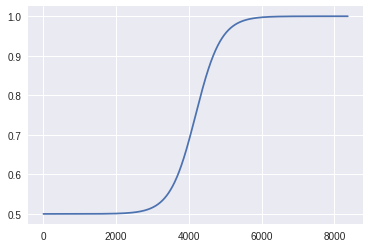

In [34]:
x_all=[X]
x_train=[X_train,Xp_train]

x_train_pred=[X_train,Xp_train]

x_test=[X_test,Xp_test]

val_data=(x_test, y_test)

# gc.collect()
# gc.collect()
# gc.collect()

# i=0.8
weights = np.linspace(start=-i, stop=i, num=y_train.shape[0])
weights = ((1 / (1 + np.exp(-weights*1)))+1)/2
pd.Series(weights).plot()
new_lr = 0.001  # Nueva tasa de aprendizaje que quieres establecer
tf.keras.backend.set_value(model.optimizer.learning_rate, new_lr)

with tf.device('/GPU:0'):
#     model.reset_states()
#     model.fit(x_train, 
#              y_train,
# #               sample_weight=weights,
#               epochs=100, 
#               batch_size=128, 
#               validation_data=val_data)
    
        model.fit(x_train, 
             y_train,
#               sample_weight=weights,
              epochs=500, 
              batch_size=256, 
              validation_data=val_data)

In [35]:
# model.save_weights('best_model3.h5')
model.load_weights('best_model3.h5')

ValueError: Layer count mismatch when loading weights from file. Model expected 240 layers, found 2647 saved layers.

In [ ]:
# model.save('model_26feb.h1')

In [36]:
x_train=[X_train,Xp_train]

x_train_pred=[X_train,Xp_train]

x_test=[X_test,Xp_test]
# from tensorflow.keras import backend as K
# K.clear_session()


y_pred=model.predict(x_test)

# y_pred=reverse_std_polarized(pd.DataFrame(y_pred,columns=y_train.columns), ystdneg, ystdpos)
y_train_pred=model.predict(x_train_pred)

262/262 [==============================] - 6s 23ms/step


********************************************
********************************************
BTC-USD
 vvv
0.4
1  peak change
-441 -1 440
             Open         Close          High           Low         y
0    16641.330078  16602.585938  16643.427734  16408.474609 -0.891188
1    16603.673828  16547.496094  16628.986328  16517.519531 -1.000000
2    16547.914062  16625.080078  16630.439453  16521.234375 -0.331563
3    16625.509766  16688.470703  16759.343750  16572.228516  0.386939
4    16688.847656  16679.857422  16760.447266  16622.371094 -0.337010
..            ...           ...           ...           ...       ...
436  68500.257812  69019.789062  70005.203125  68239.976562 -0.674183
437  69020.546875  72123.906250  72850.710938  67194.882812  1.000000
438  72125.125000  71481.289062  72825.656250  68728.851562 -0.419305
439  71471.523438  72657.421875  73634.437500  71362.945312 -0.258842
440  72657.421875  72657.421875  72657.421875  72657.421875 -1.000000

[441 rows x 5 columns]
44

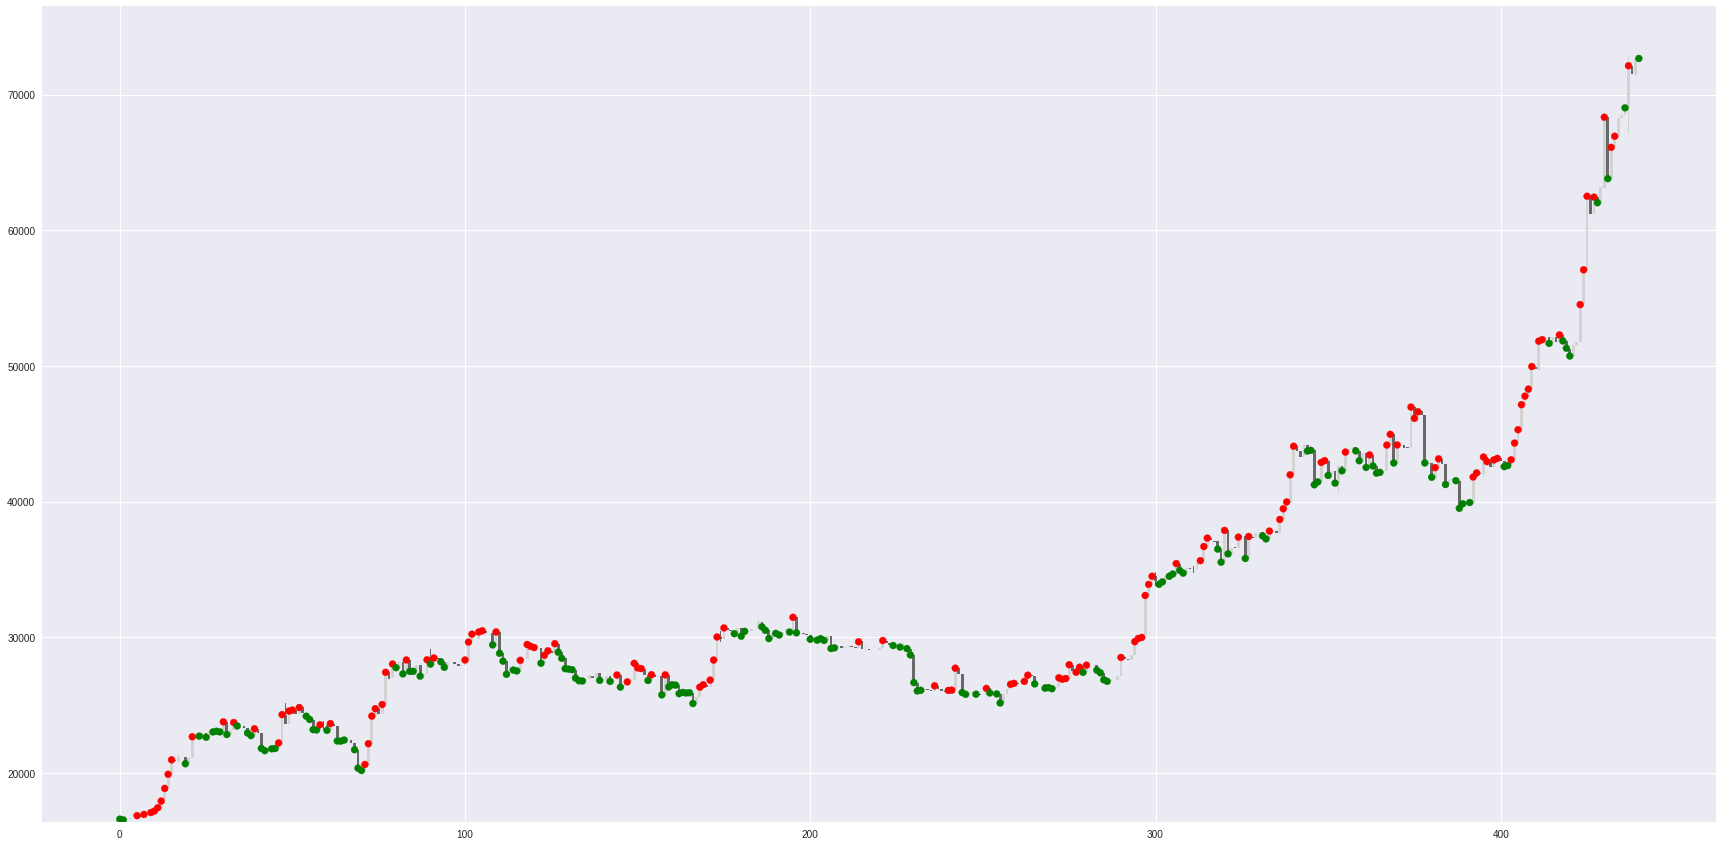

señales 1 start 10000 end 7051 | 14.7 months | oper x mes 6 total oper 97 | rate W/L 0.68 | 0.98 p/m 
1.0125  peak change
-441 -1 440
             Open         Close          High           Low         y
0    16641.330078  16602.585938  16643.427734  16408.474609 -0.734698
1    16603.673828  16547.496094  16628.986328  16517.519531 -0.809931
2    16547.914062  16625.080078  16630.439453  16521.234375 -0.483419
3    16625.509766  16688.470703  16759.343750  16572.228516 -0.094159
4    16688.847656  16679.857422  16760.447266  16622.371094 -0.213434
..            ...           ...           ...           ...       ...
436  68500.257812  69019.789062  70005.203125  68239.976562 -0.196169
437  69020.546875  72123.906250  72850.710938  67194.882812  0.693704
438  72125.125000  71481.289062  72825.656250  68728.851562  0.003984
439  71471.523438  72657.421875  73634.437500  71362.945312 -0.112317
440  72657.421875  72657.421875  72657.421875  72657.421875 -0.399936

[441 rows x 5 columns]
44

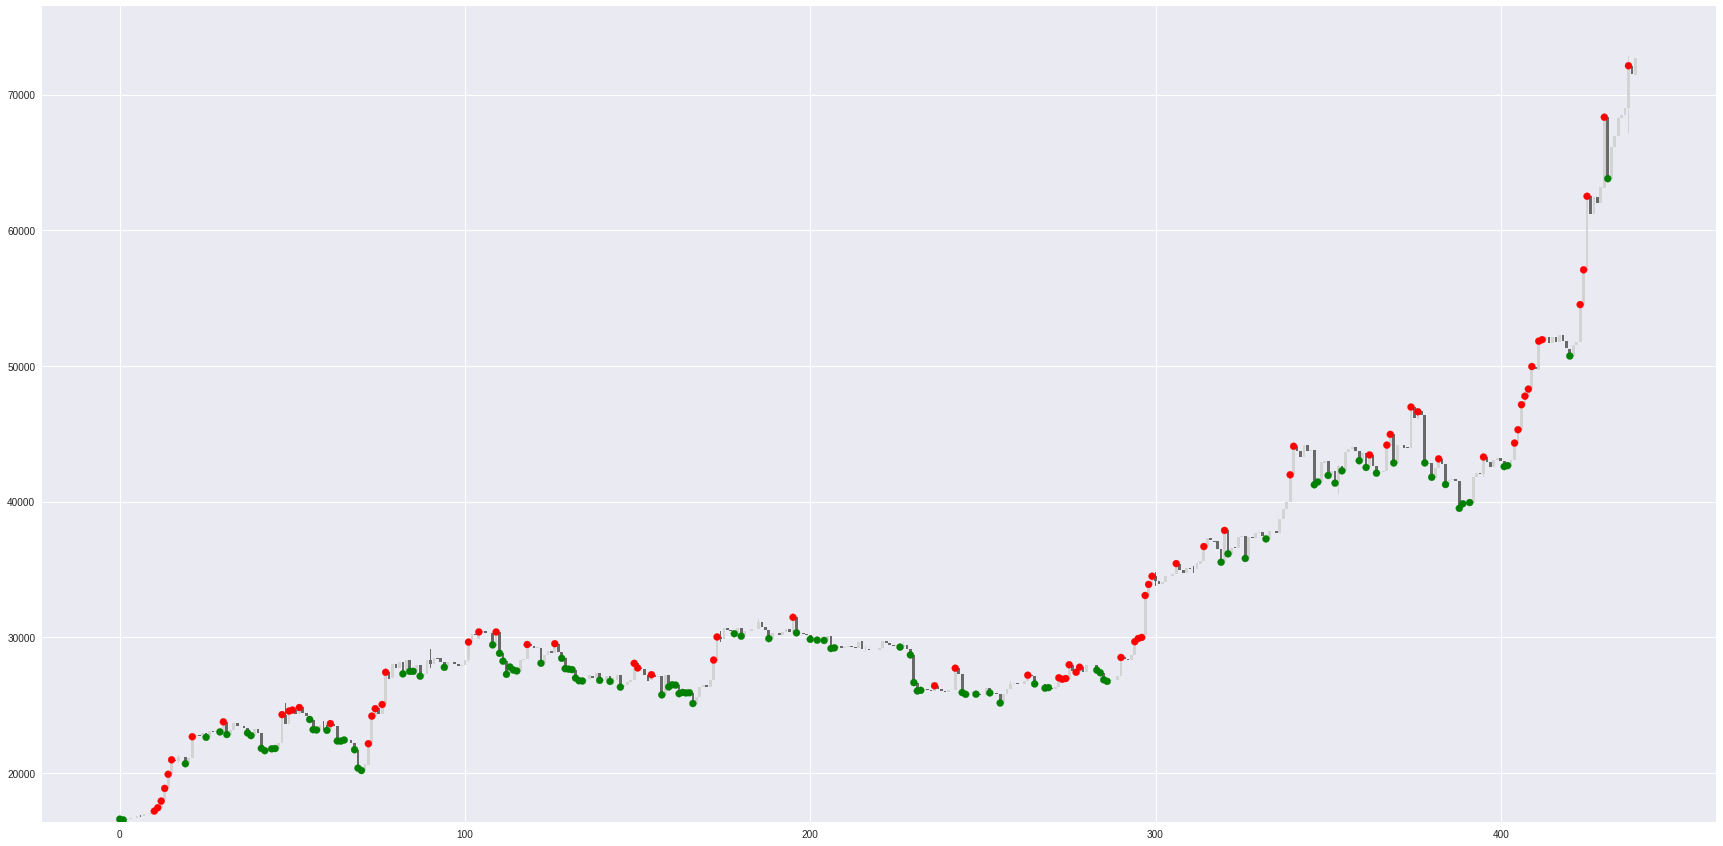

señales 1 start 10000 end 18026 | 14.7 months | oper x mes 3 total oper 54 | rate W/L 0.8 | 1.04 p/m *******
1.025  peak change
-441 -1 440
             Open         Close          High           Low         y
0    16641.330078  16602.585938  16643.427734  16408.474609 -0.796955
1    16603.673828  16547.496094  16628.986328  16517.519531 -0.834603
2    16547.914062  16625.080078  16630.439453  16521.234375 -0.642787
3    16625.509766  16688.470703  16759.343750  16572.228516 -0.338180
4    16688.847656  16679.857422  16760.447266  16622.371094 -0.228455
..            ...           ...           ...           ...       ...
436  68500.257812  69019.789062  70005.203125  68239.976562  0.032198
437  69020.546875  72123.906250  72850.710938  67194.882812  0.474585
438  72125.125000  71481.289062  72825.656250  68728.851562  0.204737
439  71471.523438  72657.421875  73634.437500  71362.945312 -0.020597
440  72657.421875  72657.421875  72657.421875  72657.421875 -0.171562

[441 rows x 5 colum

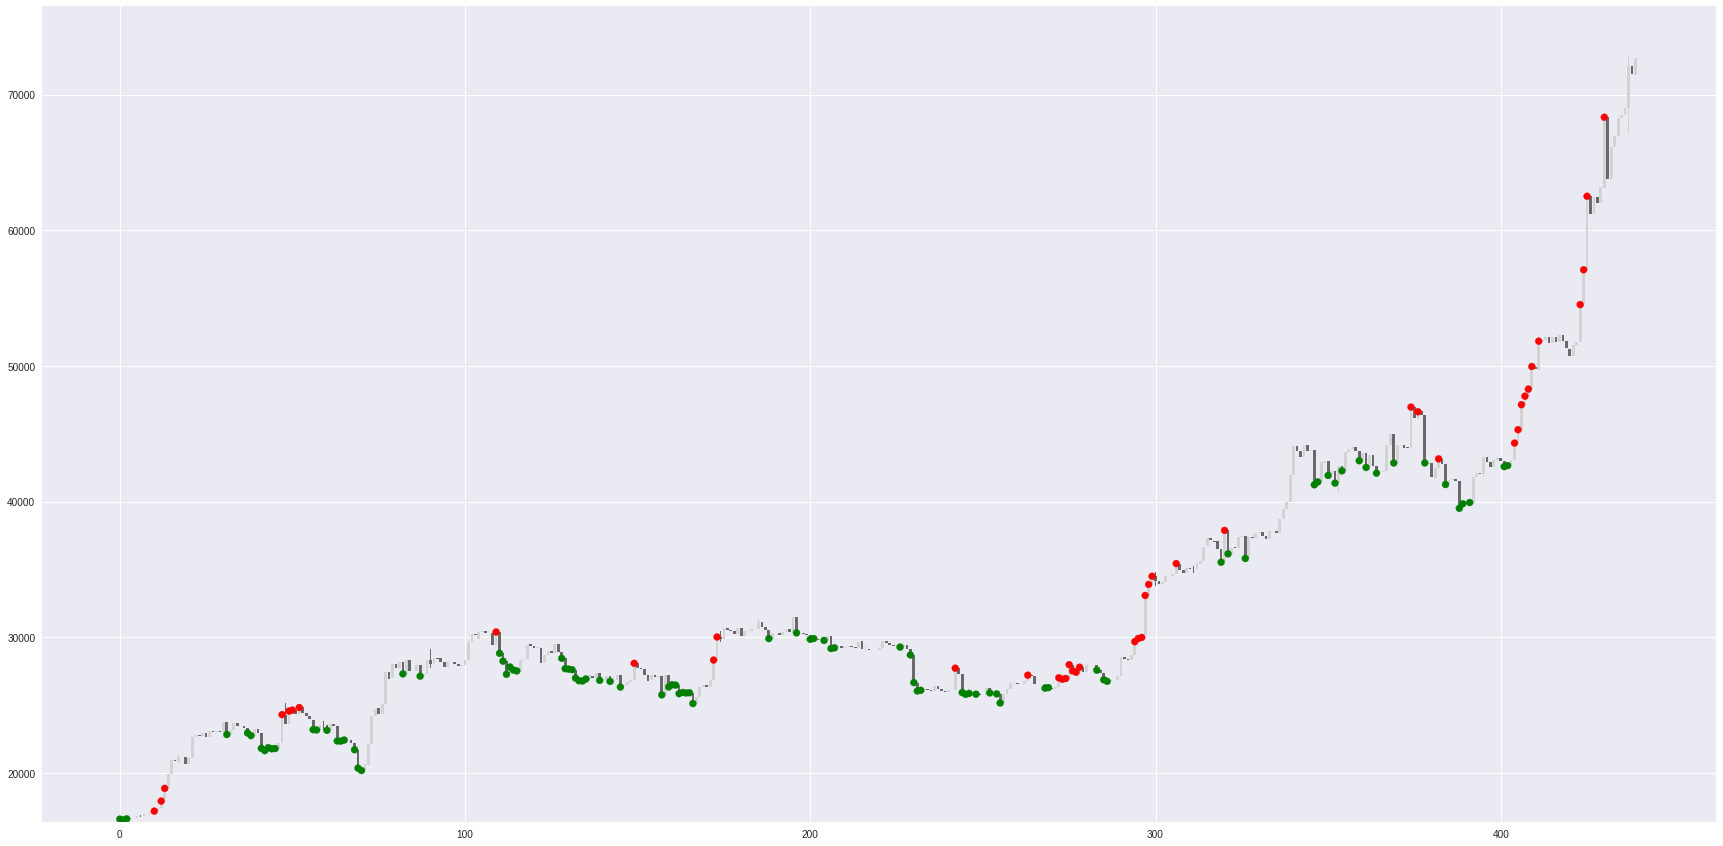

señales 1 start 10000 end 6840 | 14.7 months | oper x mes 1 total oper 26 | rate W/L 0.77 | 0.97 p/m 
1.05  peak change
-441 -1 440
             Open         Close          High           Low         y
0    16641.330078  16602.585938  16643.427734  16408.474609 -0.838796
1    16603.673828  16547.496094  16628.986328  16517.519531 -0.844816
2    16547.914062  16625.080078  16630.439453  16521.234375 -0.777117
3    16625.509766  16688.470703  16759.343750  16572.228516 -0.562704
4    16688.847656  16679.857422  16760.447266  16622.371094 -0.276275
..            ...           ...           ...           ...       ...
436  68500.257812  69019.789062  70005.203125  68239.976562  0.217232
437  69020.546875  72123.906250  72850.710938  67194.882812  0.297981
438  72125.125000  71481.289062  72825.656250  68728.851562  0.330061
439  71471.523438  72657.421875  73634.437500  71362.945312  0.045873
440  72657.421875  72657.421875  72657.421875  72657.421875 -0.001786

[441 rows x 5 columns]
440 

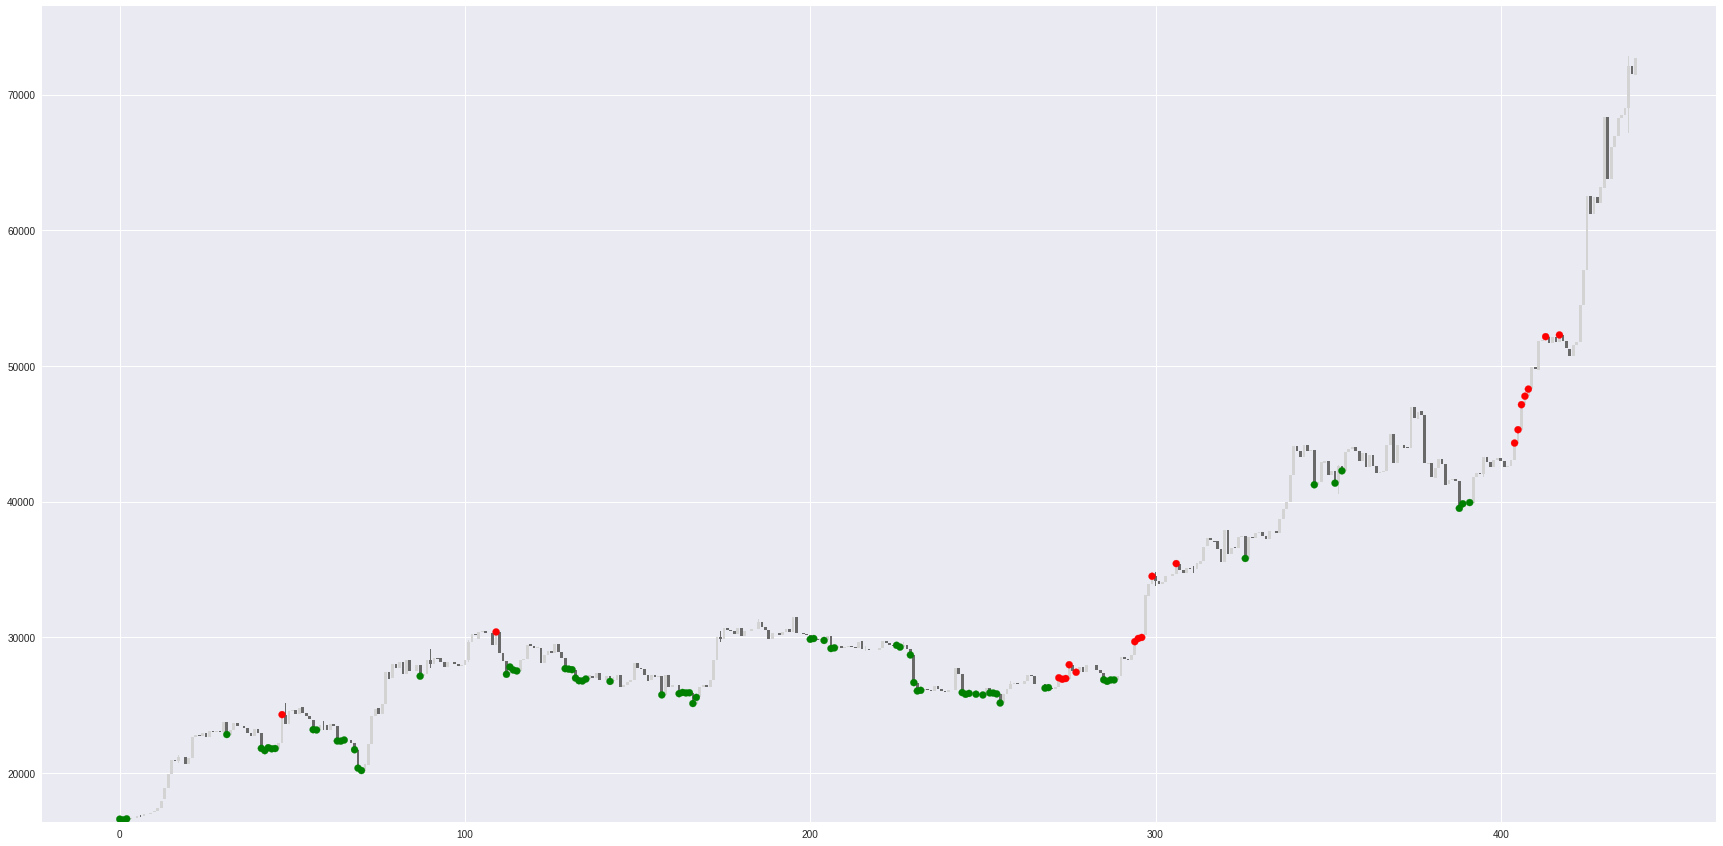

señales 1 start 10000 end 8534 | 14.7 months | oper x mes 0 total oper 10 | rate W/L 0.8 | 0.99 p/m 
1.1  peak change
-441 -1 440
             Open         Close          High           Low         y
0    16641.330078  16602.585938  16643.427734  16408.474609 -0.864025
1    16603.673828  16547.496094  16628.986328  16517.519531 -0.849681
2    16547.914062  16625.080078  16630.439453  16521.234375 -0.878591
3    16625.509766  16688.470703  16759.343750  16572.228516 -0.740060
4    16688.847656  16679.857422  16760.447266  16622.371094 -0.340103
..            ...           ...           ...           ...       ...
436  68500.257812  69019.789062  70005.203125  68239.976562  0.369738
437  69020.546875  72123.906250  72850.710938  67194.882812  0.253575
438  72125.125000  71481.289062  72825.656250  68728.851562  0.381747
439  71471.523438  72657.421875  73634.437500  71362.945312  0.096712
440  72657.421875  72657.421875  72657.421875  72657.421875  0.087800

[441 rows x 5 columns]
440 da

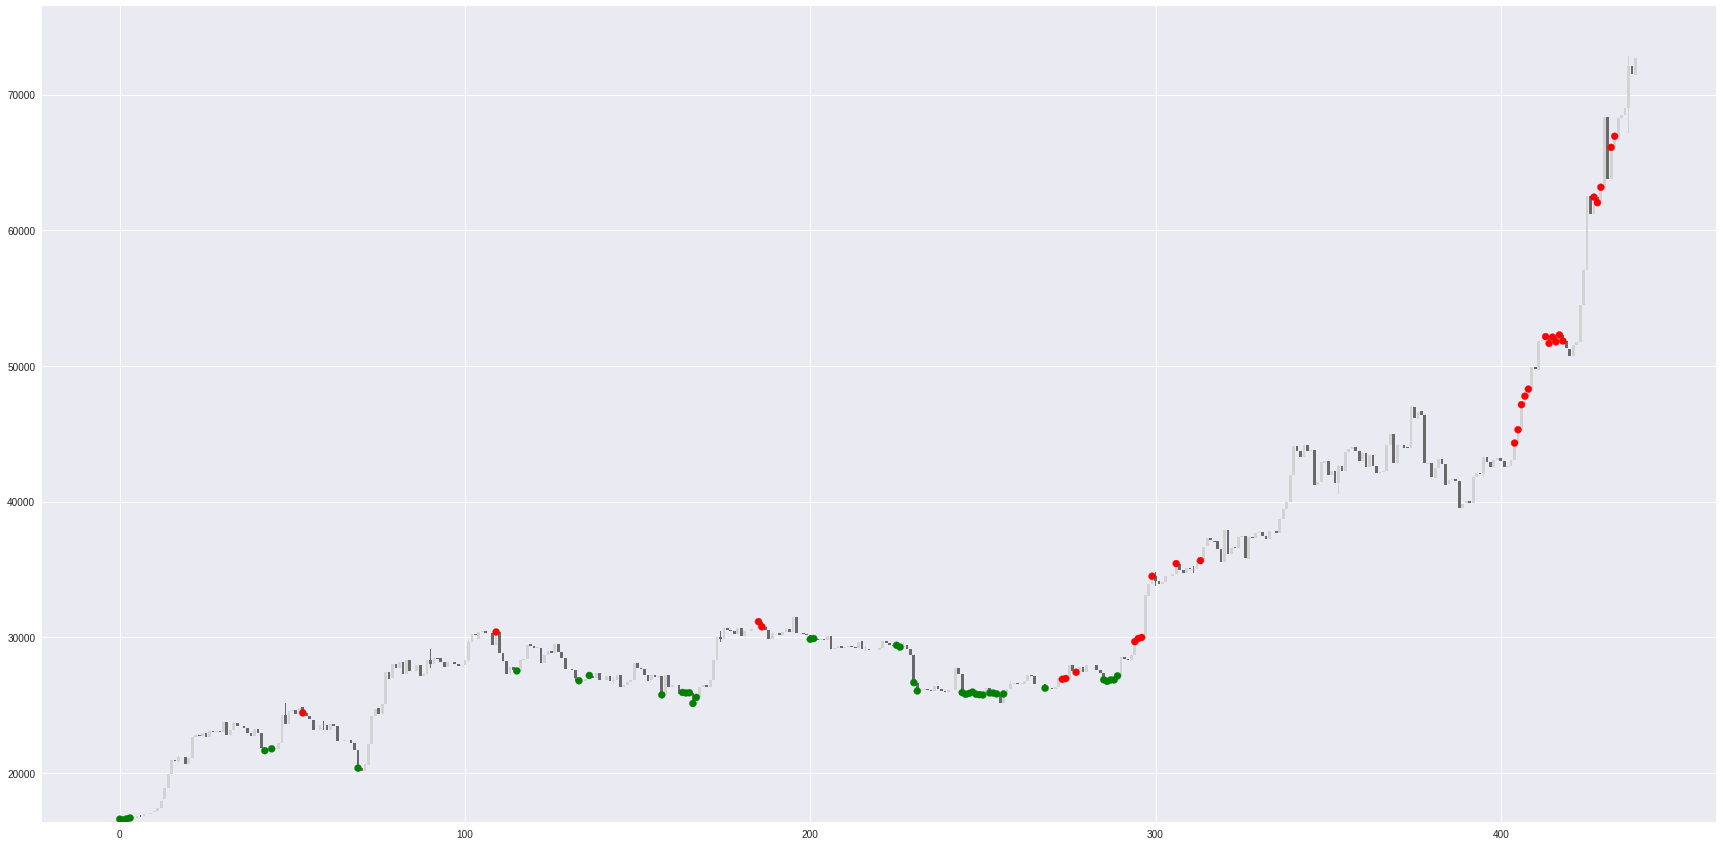

señales 1 start 10000 end 0 | 14.7 months | oper x mes 0 total oper 10 | rate W/L 0.9 | 0.0 p/m 
1.2  peak change
-441 -1 440
             Open         Close          High           Low         y
0    16641.330078  16602.585938  16643.427734  16408.474609 -0.731759
1    16603.673828  16547.496094  16628.986328  16517.519531 -0.712948
2    16547.914062  16625.080078  16630.439453  16521.234375 -0.775745
3    16625.509766  16688.470703  16759.343750  16572.228516 -0.696513
4    16688.847656  16679.857422  16760.447266  16622.371094 -0.330502
..            ...           ...           ...           ...       ...
436  68500.257812  69019.789062  70005.203125  68239.976562  0.445368
437  69020.546875  72123.906250  72850.710938  67194.882812  0.277878
438  72125.125000  71481.289062  72825.656250  68728.851562  0.409387
439  71471.523438  72657.421875  73634.437500  71362.945312  0.186178
440  72657.421875  72657.421875  72657.421875  72657.421875  0.192214

[441 rows x 5 columns]
440 days
1

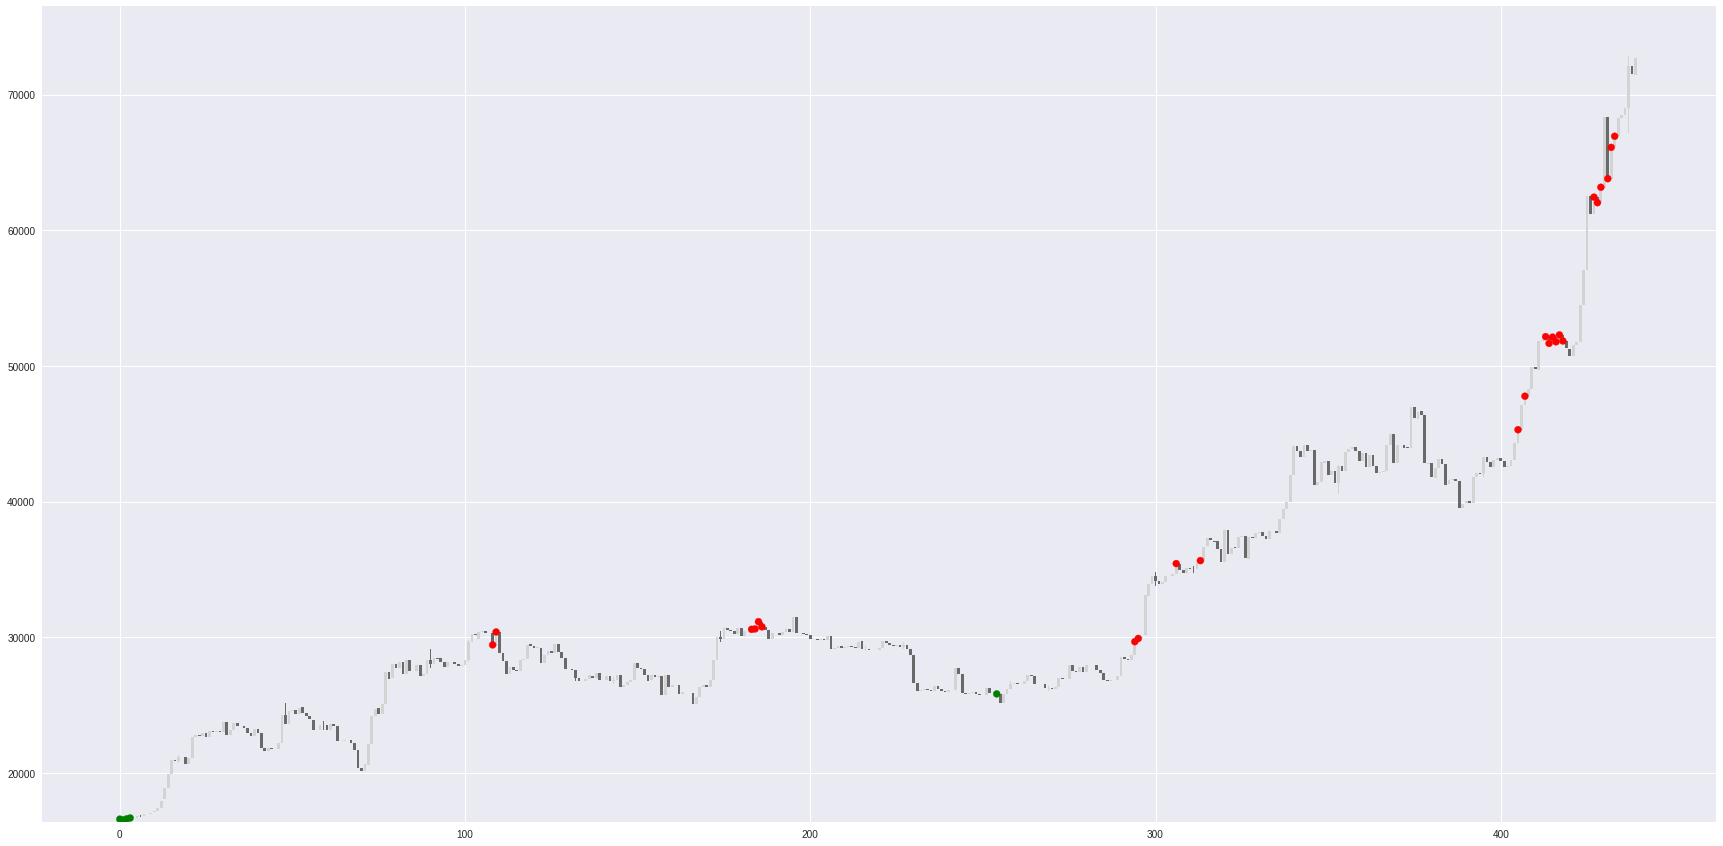

señales 1 start 10000 end 0 | 14.7 months | oper x mes 0 total oper 4 | rate W/L 1.0 | 0.0 p/m 


In [37]:
train=False
if train:
#     df_test=df[buscar(df,'_','_y')][:y_train.shape[0]+91]
    df_test=pd.DataFrame(X_train[:,-1,:],columns=buscar(df,'_','_y|pico|pos'))
    df_test[buscar(df,'_y','pi|ant|dir')]=y_train_pred
    # df_test=df_test[buscar(df_test,'_y','pike')]
    df_test=df_test[-500:]

else:
    df_test=pd.DataFrame(X_test[:,-1,:],columns=buscar(df,'_','_y|pico|pos'))
    df_test[buscar(df,'_y','pi|ant|dir')]=y_pred
    df_test=df_test[-500:]
# df_test=df_test[buscar(df_test,'_','dir')]
# for s in symbols:
for s in ['BTC-USD']:
    print('********************************************')
    print('********************************************')
    print(s)
    print(' vvv')
    if s=='WFC':
        df_test2=df_test[buscar(df_test,s+'_','BABA')].copy()
    else:
        df_test2=df_test[buscar(df_test,s+'_')].copy()
#     df_test2[buscar(df_test2,'pike')]=(df_test2[buscar(df_test2,'pike')]+1).values*df_test2[buscar(df_test2,'Close')].values
    
#     pct=0.2
    margen=0.4
#     for margen in np.array([0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5])*2:
    
    for margen in np.array([margen]):
#         print('a')
        margen2=0
        margeni=margen
        margens=margen
        print(margen)
        margen2i=margeni
        margen2s=margens
        stop=50
        profit=50

        for peak in peak_changes:
#         for peak in ['1']:
            print(str(peak),' peak change')
            df_test3=df_test2.drop(columns=buscar(df_test2,'_y'))
            df_test3[s+'_'+str(peak)+'_y']=df_test2[s+'_'+str(peak)+'_y']
#             df_test3[s+str(peak)+'_y']=df_test2[s+str(peak)+'_y']
#             df_test3[s+'_y'+'_'+str(peak)]=df_test2[s+'_y'+'_'+str(peak)]
#             wy=np.array([3,2,2,1,1])
#             wy=wy/wy.sum()

#             df_test3[s+'_y'+'_'+str(peak)]=(df_test2[buscar(df_test2,'_y')]*wy).sum(axis=1)
    
#             df_test
            df_test3=df_test3.reset_index(drop=True)
#             print(df_test3)
            ver(df_test3,s,margen,5000,5000,first=False)
            simulacion(df_test3,margeni,margens,margen2i,margen2s,stop,profit,200,1,show=False)


In [ ]:
# df[buscar(df[buscar(df,'CMR','FTSE')],'Close')].plot()

In [ ]:
df_test[buscar(df_test,'ADA')]

In [ ]:
marg=0.95
# Suponiendo que y_pred y y_test son DataFrames de pandas
# a=pd.DataFrame(y_pred,columns=y.columns)
a=pd.DataFrame(y_train_pred,columns=y.columns)

# a=a.drop(columns=buscar(a,'_1_|_1.01_')).reset_index(drop=True)
# a=a[buscar(a,'-USD')].reset_index(drop=True)
# Seleccionar la última fila
last_row = a.iloc[-1]

# Filtrar valores cuyo valor absoluto sea mayor a marg
filtered = last_row[last_row.abs() > marg]

# filtered=filtered.sort_values()

# Asignar colores según el signo del valor
colors = ['red' if x > 0 else 'green' for x in filtered]

# Crear el gráfico de barras horizontales
plt.figure(figsize=(10, 20))
filtered.plot(kind='barh', color=colors)

# Mostrar el gráfico
plt.show()


In [ ]:
df_test[buscar(df_test,'ARS')]

In [ ]:
y_pred=np.array(y_preds)

In [ ]:
df

In [ ]:
df_test2

In [ ]:
df_test=df[buscar(df,'_','_y')][-y_pred.shape[0]:]
df_test[buscar(df,'_y')]=y_pred+1
for s in symbols:
    df_test[buscar(df_test[buscar(df_test,s)],'_y')]=df_test[buscar(df_test[buscar(df_test,s)],'Close')].values*df_test[buscar(df_test[buscar(df_test,s)],'_y')].values

In [ ]:
df_test

In [ ]:
df_test

In [ ]:
buscar(df_test2,str(peak))

In [ ]:
df_test3[s+'_'+str(peak)+'_y']=df_test2[buscar(df_test2,str(peak))]

In [ ]:
df_test2[buscar(df_test2,'Close')]

In [ ]:
# Números a formatear
numero_positivo = 42.123555
numero_negativo = -42.123456

# Formatear los números para redondear a 3 decimales, incluir un espacio para el signo en caso de ser positivos
# y asegurar que el ancho total incluya espacio para el signo, el punto decimal y tres dígitos decimales
numero_positivo_formateado = f"{numero_positivo: 2.3f}"  # Ajusta el ancho total si es necesario
numero_negativo_formateado = f"{numero_negativo: 2.3f}"

print(f"'{numero_positivo_formateado}'") # Muestra el número positivo con un espacio para el signo
print(f"'{numero_negativo_formateado}'") # Muestra el número negativo con su signo


In [ ]:
df_test2

In [ ]:
[l.name for l in layers]

In [ ]:
import seaborn as sns
# Obtener la lista de capas del modelo
layers = model.layers

# Buscar la capa que quieres inspeccionar (en este caso, adj1)
target_layer_name = 'normalizer6'  # Reemplaza con el nombre de tu capa
target_layer = None

for layer in layers:
    if layer.name == target_layer_name:
        target_layer = layer
        break
# Crear un modelo con la capa de interés como salida
partial_model = Model(inputs=model.input, outputs=target_layer.output)

# Preprocesar tus datos de entrada si es necesario (reemplaza X_val e Y_val con tus datos)
# input_data = [X_val, pear_input_data]  # Asegúrate de que coincida con la estructura de entrada del modelo
# Realizar la predicción
output_data = partial_model.predict(x_train)

In [ ]:
output_data

In [ ]:
df.describe()

In [ ]:
import seaborn as sns
# Obtener la lista de capas del modelo
layers = model.layers

# Buscar la capa que quieres inspeccionar (en este caso, adj1)
target_layer_name = 'adj1'  # Reemplaza con el nombre de tu capa
target_layer = None

for layer in layers:
    if layer.name == target_layer_name:
        target_layer = layer
        break
# Crear un modelo con la capa de interés como salida
partial_model = Model(inputs=model.input, outputs=target_layer.output)

# Preprocesar tus datos de entrada si es necesario (reemplaza X_val e Y_val con tus datos)
# input_data = [X_val, pear_input_data]  # Asegúrate de que coincida con la estructura de entrada del modelo
# Realizar la predicción
output_data = partial_model.predict(x_train)

# Imprimir los valores de salida
print("Salida de", target_layer_name)
weights=output_data[-100].reshape(22,22)

weightsshow=weights
# Crear un mapa de calor con seaborn
sns.set(font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.heatmap(weightsshow, annot=False, 
            cmap="RdBu", 
            fmt=".2f", 
            linewidths=.5, 
            square=True, 
            cbar_kws={"shrink": 0.7})

# Agregar etiquetas
plt.xlabel("Columnas")
plt.ylabel("Filas")
plt.title("Mapa de Calor de Pesos")

# Mostrar el mapa de calor
plt.show()


In [ ]:
a

In [ ]:

epochs = 1
batch_size = 1  # Asume un tamaño de batch fijo por simplicidad

# Calcular el número total de batches
mask_train=(y_train!=-10).values*1.0
mask_train2=(y_train!=-20).values*1.0
mask_test=(y_test!=-20).values*1.0




total_batches = len(X_train) // batch_size
# memory_pool = np.zeros(((1, 10, 5)))
memory_ind = np.zeros(((1, maxlen, 4)))
memory_layer_ind = Model(inputs=model.input, outputs=model.get_layer('memory').output)
memory_layer_ind0 = Model(inputs=model.input, outputs=model.get_layer('0memory').output)
# memory_layer_pool = Model(inputs=model.input, outputs=model.get_layer('MemoryPool').output)

for epoch in range(epochs):
    print(f"Comenzando Época {epoch+1}")

    for batch_index in range(total_batches):
        if batch_index==0:
            memory_ind = np.zeros(((batch_size, maxlen, nodes)))
#             memory_pool = np.zeros(((1, 50, 5)))
        # Seleccionar secuencialmente un batch de datos
        start_index = batch_index * batch_size
        end_index = start_index + batch_size
        print(start_index,end_index)
        batch_x_train = X_train[start_index:end_index]
        batch_mask_train = mask_train[start_index:end_index]
#         batch_xp_train = Xp_train[start_index:end_index]
        batch_y = y_train[start_index:end_index].values
        batch_x=[np.array(batch_x_train),np.array(batch_mask_train),np.array(memory_ind)]
        
        # Entrenar el modelo con este batch
        print(' batch',batch_index)
        model.train_on_batch(batch_x, batch_y)
#         print(' batch',batch_index)
        
        # Si necesitas obtener los valores de la capa de memoria después de cada batch
#         memory_output = Model(inputs=model.input, 
#                       outputs=model.get_layer('Memory').output)        
        
        memory_ind = memory_layer_ind.predict(batch_x)
        memory_ind2 = memory_layer_ind0.predict(batch_x)
#         memory_pool = memory_layer_pool.predict(batch_x)

        print(memory_ind)
        print(memory_ind2)
    print(f"Época {epoch+1} completada.")


    
    #x_test=[X_test,Xp_test]

total_batches = len(X_test) // batch_size

y_preds=[]
for batch_index in range(total_batches):
    start_index = batch_index * batch_size
    end_index = start_index + batch_size
    print(start_index,end_index)
    batch_x_test = X_test[start_index:end_index]
    batch_mask_test = mask_test[start_index:end_index]
    #batch_xp_test = Xp_test[start_index:end_index]
#     batch_y = y_test[start_index:end_index]
    batch_x_test=[np.array(batch_x_test),np.array(batch_mask_test),np.array(memory_ind)]
    y_preds.append(model.predict(batch_x_test).reshape(-1))
    memory_ind = memory_layer_ind.predict(batch_x_test)
#     print(memory_ind)